Mean MSE over 50 curves: 2.27792e+04


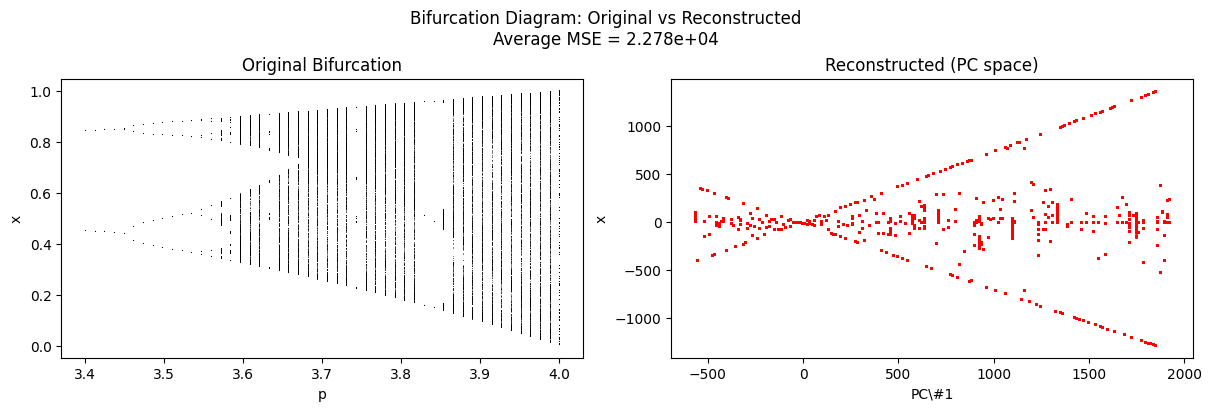

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

# Generate logistic‐map data
def generate_logistic_map(p_values, num_points=2000, noise_std=0.0001):
    """Generate logistic‐map time series without observational noise."""
    all_series = []
    for p in p_values:
        x = np.zeros(num_points)
        x[0] = np.random.uniform(0.1, 0.9)
        for t in range(num_points - 1):
            x[t+1] = p * x[t] * (1 - x[t])
            x[t+1] = np.clip(x[t+1], 0.001, 0.999)
        all_series.append(x)
    return np.array(all_series)

# parameter grid for original bifurcation
p_values = np.linspace(3.4, 4.0, 50)
time_series = generate_logistic_map(p_values, num_points=2000)

# Define ELM and training func

class ELM(torch.nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.input_layer = torch.nn.Linear(1, hidden_size, bias=True)
        torch.nn.init.normal_(self.input_layer.weight, std=0.1)
        self.activation = torch.nn.Sigmoid()
        self.output_layer = torch.nn.Linear(hidden_size, 1, bias=False)
        # freeze input weights
        for param in self.input_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.activation(self.input_layer(x))
        return self.output_layer(h)

def train_elms(series_list, hidden_size=8, reg=1e-3):
    """
    Train one ELM per parameter.  
    Returns list of trained ELMs and array of output weight vectors.
    """
    elms, weights = [], []
    for series in series_list:
        # normalize
        s = (series - series.mean()) / series.std()
        X = torch.FloatTensor(s[:-1]).unsqueeze(1)  # (T-1,1)
        Y = torch.FloatTensor(s[1: ]).unsqueeze(1)  # (T-1,1)
        elm = ELM(hidden_size=hidden_size)
        with torch.no_grad():
            H = elm.activation(elm.input_layer(X))  # (T-1, hidden)
            H_np = H.numpy()
            y_np = Y.numpy()
            # solve (H^T H + reg I) W = H^T y
            W = np.linalg.solve(H_np.T @ H_np + reg*np.eye(hidden_size),
                                H_np.T @ y_np)
        elm.output_layer.weight.data = torch.FloatTensor(W.T)
        elms.append(elm)
        weights.append(W.flatten())
    return elms, np.array(weights)

elms, output_weights = train_elms(time_series, hidden_size=2, reg=1e-3)

# PCA on output weights → 1D manifold

pca = PCA(n_components=1)
pc_scores = pca.fit_transform(output_weights)        # (50,1)
pc_range = np.linspace(pc_scores.min(),
                       pc_scores.max(),
                       200).reshape(-1,1)          # (200,1)

# Reconstruction function

def reconstruct_bifurcation(elms, pca, pc_range, steps=1000, burn_in=500):
    """
    Given a range along the first principal component, reconstruct
    time series via virtual ELMs.
    """
    hidden = elms[0].input_layer.out_features
    # map back to weight space
    W_range = pca.inverse_transform(pc_range)         # (200, hidden)
    recon = np.zeros((len(pc_range), steps))
    for i, W in enumerate(W_range):
        elm = ELM(hidden_size=hidden)
        # set output weights
        elm.output_layer.weight.data = torch.FloatTensor(W.reshape(1,-1))
        # simulate one‐step map: x_{n+1} = elm(x_n)
        x = torch.FloatTensor([[0.5]])
        traj = []
        for n in range(burn_in + steps):
            x = elm(x)
            traj.append(x.item())
        recon[i] = traj[burn_in:]
    return recon

reconstructed = reconstruct_bifurcation(elms, pca, pc_range,
                                       steps=1000, burn_in=500)


# Compute MSE against original

# Interpolating original to same length and latent axis
# Here: comparing first 50 reconstructed series to originals
mse_list = []
for i in range(len(p_values)):
    orig = time_series[i, -1000:]     # last 1000 points
    rec  = reconstructed[i, :1000]
    mse_list.append(np.mean((orig - rec)**2))
print(f"Mean MSE over {len(p_values)} curves: {np.mean(mse_list):.5e}")

# Visualization

fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)

# (a) Original bifurcation
axes[0].set_title("Original Bifurcation")
for p, series in zip(p_values, time_series):
    axes[0].plot([p]*1000, series[-1000:], 'k,', alpha=0.5)
axes[0].set_xlabel("p"); axes[0].set_ylabel("x")

# (b) Reconstructed bifurcation (PC axis)
axes[1].set_title("Reconstructed (PC space)")
for pc, series in zip(pc_range.flatten(), reconstructed):
    axes[1].plot(
        [pc] * len(series),
        series,
        color='red',
        marker='.',
        linestyle='None',
        alpha=0.5,
        markersize=2  # increase this number for larger dots
    )
axes[1].set_xlabel("PC\#1"); axes[1].set_ylabel("x")

plt.suptitle("Bifurcation Diagram: Original vs Reconstructed\n"
             f"Average MSE = {np.mean(mse_list):.3e}")
plt.show()


Mean MSE over 50 curves: 2.94075e+03


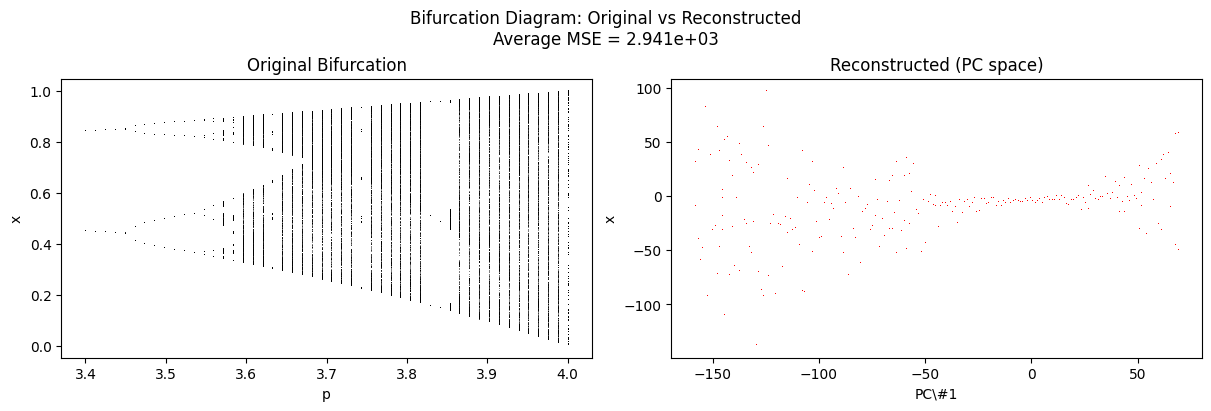

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

# ================================
# 1. Generate logistic‐map data
# ================================
def generate_logistic_map(p_values, num_points=2000, noise_std=0.0001):
    """Generate logistic‐map time series without observational noise."""
    all_series = []
    for p in p_values:
        x = np.zeros(num_points)
        x[0] = np.random.uniform(0.1, 0.9)
        for t in range(num_points - 1):
            x[t+1] = p * x[t] * (1 - x[t])
            x[t+1] = np.clip(x[t+1], 0.001, 0.999)
        all_series.append(x)
    return np.array(all_series)

# parameter grid for original bifurcation
p_values = np.linspace(3.4, 4.0, 50)
time_series = generate_logistic_map(p_values, num_points=2000)

# =================================
# 2. Define ELM and training func
# =================================
class ELM(torch.nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.input_layer = torch.nn.Linear(1, hidden_size, bias=True)
        torch.nn.init.normal_(self.input_layer.weight, std=0.1)
        self.activation = torch.nn.Sigmoid()
        self.output_layer = torch.nn.Linear(hidden_size, 1, bias=False)
        # freeze input weights
        for param in self.input_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.activation(self.input_layer(x))
        return self.output_layer(h)

def train_elms(series_list, hidden_size=8, reg=1e-3):
    """
    Train one ELM per parameter.  
    Returns list of trained ELMs and array of output weight vectors.
    """
    elms, weights = [], []
    for series in series_list:
        # normalize
        s = (series - series.mean()) / series.std()
        X = torch.FloatTensor(s[:-1]).unsqueeze(1)  # (T-1,1)
        Y = torch.FloatTensor(s[1: ]).unsqueeze(1)  # (T-1,1)
        elm = ELM(hidden_size=hidden_size)
        with torch.no_grad():
            H = elm.activation(elm.input_layer(X))  # (T-1, hidden)
            H_np = H.numpy()
            y_np = Y.numpy()
            # solve (H^T H + reg I) W = H^T y
            W = np.linalg.solve(H_np.T @ H_np + reg*np.eye(hidden_size),
                                H_np.T @ y_np)
        elm.output_layer.weight.data = torch.FloatTensor(W.T)
        elms.append(elm)
        weights.append(W.flatten())
    return elms, np.array(weights)

elms, output_weights = train_elms(time_series, hidden_size=4, reg=1e-2)

# =====================================
# 3. PCA on output weights → 1D manifold
# =====================================
pca = PCA(n_components=1)
pc_scores = pca.fit_transform(output_weights)        # (50,1)
pc_range = np.linspace(pc_scores.min(),
                       pc_scores.max(),
                       200).reshape(-1,1)          # (200,1)

# ====================================
# 4. Reconstruction function
# ====================================
def reconstruct_bifurcation(elms, pca, pc_range, steps=1000, burn_in=500):
    """
    Given a range along the first principal component, reconstruct
    time series via virtual ELMs.
    """
    hidden = elms[0].input_layer.out_features
    # map back to weight space
    W_range = pca.inverse_transform(pc_range)         # (200, hidden)
    recon = np.zeros((len(pc_range), steps))
    for i, W in enumerate(W_range):
        elm = ELM(hidden_size=hidden)
        # set output weights
        elm.output_layer.weight.data = torch.FloatTensor(W.reshape(1,-1))
        # simulate one‐step map: x_{n+1} = elm(x_n)
        x = torch.FloatTensor([[0.5]])
        traj = []
        for n in range(burn_in + steps):
            x = elm(x)
            traj.append(x.item())
        recon[i] = traj[burn_in:]
    return recon

reconstructed = reconstruct_bifurcation(elms, pca, pc_range,
                                       steps=1000, burn_in=500)

# ====================================
# 5. Compute MSE against original
# ====================================
# Interpolate original to same length and latent axis
# Here: compare first 50 reconstructed series to originals
mse_list = []
for i in range(len(p_values)):
    orig = time_series[i, -1000:]     # last 1000 points
    rec  = reconstructed[i, :1000]
    mse_list.append(np.mean((orig - rec)**2))
print(f"Mean MSE over {len(p_values)} curves: {np.mean(mse_list):.5e}")

# ====================================
# 6. Visualization
# ====================================
fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)

# (a) Original bifurcation
axes[0].set_title("Original Bifurcation")
for p, series in zip(p_values, time_series):
    axes[0].plot([p]*1000, series[-1000:], 'k,', alpha=0.5)
axes[0].set_xlabel("p"); axes[0].set_ylabel("x")

# (b) Reconstructed bifurcation (PC axis)
axes[1].set_title("Reconstructed (PC space)")
for pc, series in zip(pc_range.flatten(), reconstructed):
    axes[1].plot([pc]*1000, series, 'r,', alpha=0.5)
axes[1].set_xlabel("PC\#1"); axes[1].set_ylabel("x")

plt.suptitle("Bifurcation Diagram: Original vs Reconstructed\n"
             f"Average MSE = {np.mean(mse_list):.3e}")
plt.show()


Mean MSE over 50 curves: 1.26928e+03


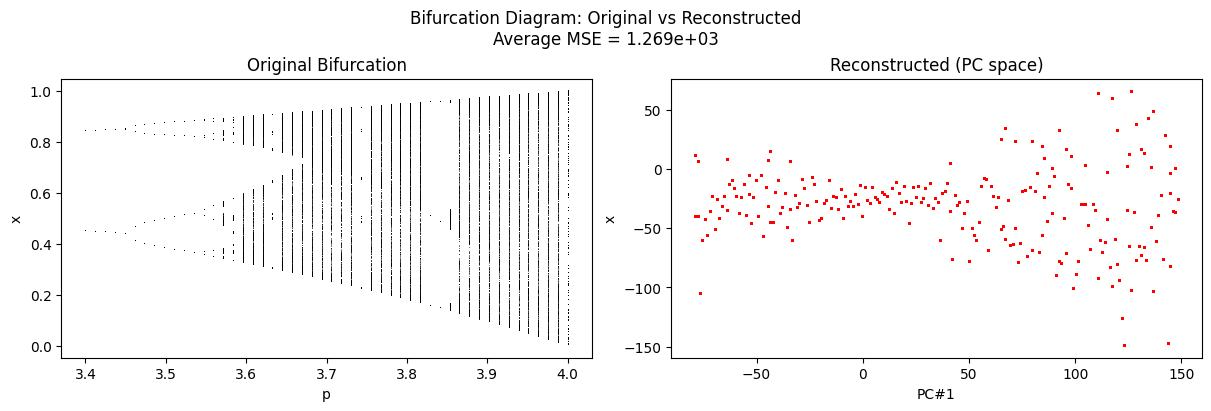

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

# ================================
# 1. Generate logistic‐map data
# ================================
def generate_logistic_map(p_values, num_points=2000, noise_std=0.0001):
    """Generate logistic‐map time series without observational noise."""
    all_series = []
    for p in p_values:
        x = np.zeros(num_points)
        x[0] = np.random.uniform(0.1, 0.9)
        for t in range(num_points - 1):
            x[t+1] = p * x[t] * (1 - x[t])
            x[t+1] = np.clip(x[t+1], 0.001, 0.999)
        all_series.append(x)
    return np.array(all_series)

# parameter grid for original bifurcation
p_values = np.linspace(3.4, 4.0, 50)
time_series = generate_logistic_map(p_values, num_points=2000)

# =================================
# 2. Define ELM and training func
# =================================
class ELM(torch.nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.input_layer = torch.nn.Linear(1, hidden_size, bias=True)
        torch.nn.init.normal_(self.input_layer.weight, std=0.1)
        self.activation = torch.nn.Sigmoid()
        self.output_layer = torch.nn.Linear(hidden_size, 1, bias=False)
        # freeze input weights
        for param in self.input_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.activation(self.input_layer(x))
        return self.output_layer(h)

def train_elms(series_list, hidden_size=8, reg=1e-3):
    """
    Train one ELM per parameter.  
    Returns list of trained ELMs and array of output weight vectors.
    """
    elms, weights = [], []
    for series in series_list:
        # normalize
        s = (series - series.mean()) / series.std()
        X = torch.FloatTensor(s[:-1]).unsqueeze(1)  # (T-1,1)
        Y = torch.FloatTensor(s[1: ]).unsqueeze(1)  # (T-1,1)
        elm = ELM(hidden_size=hidden_size)
        with torch.no_grad():
            H = elm.activation(elm.input_layer(X))  # (T-1, hidden)
            H_np = H.numpy()
            y_np = Y.numpy()
            # solve (H^T H + reg I) W = H^T y
            W = np.linalg.solve(H_np.T @ H_np + reg*np.eye(hidden_size),
                                H_np.T @ y_np)
        elm.output_layer.weight.data = torch.FloatTensor(W.T)
        elms.append(elm)
        weights.append(W.flatten())
    return elms, np.array(weights)

elms, output_weights = train_elms(time_series, hidden_size=12, reg=1e-2)

# =====================================
# 3. PCA on output weights → 1D manifold
# =====================================
pca = PCA(n_components=1)
pc_scores = pca.fit_transform(output_weights)        # (50,1)
pc_range = np.linspace(pc_scores.min(),
                       pc_scores.max(),
                       200).reshape(-1,1)          # (200,1)

# ====================================
# 4. Reconstruction function
# ====================================
def reconstruct_bifurcation(elms, pca, pc_range, steps=1000, burn_in=500):
    """
    Given a range along the first principal component, reconstruct
    time series via virtual ELMs.
    """
    hidden = elms[0].input_layer.out_features
    # map back to weight space
    W_range = pca.inverse_transform(pc_range)         # (200, hidden)
    recon = np.zeros((len(pc_range), steps))
    for i, W in enumerate(W_range):
        elm = ELM(hidden_size=hidden)
        # set output weights
        elm.output_layer.weight.data = torch.FloatTensor(W.reshape(1,-1))
        # simulate one‐step map: x_{n+1} = elm(x_n)
        x = torch.FloatTensor([[0.5]])
        traj = []
        for n in range(burn_in + steps):
            x = elm(x)
            traj.append(x.item())
        recon[i] = traj[burn_in:]
    return recon

reconstructed = reconstruct_bifurcation(elms, pca, pc_range,
                                       steps=10000, burn_in=500)

# ====================================
# 5. Compute MSE against original
# ====================================
# Interpolate original to same length and latent axis
# Here: compare first 50 reconstructed series to originals
mse_list = []
for i in range(len(p_values)):
    orig = time_series[i, -1000:]     # last 1000 points
    rec  = reconstructed[i, :1000]
    mse_list.append(np.mean((orig - rec)**2))
print(f"Mean MSE over {len(p_values)} curves: {np.mean(mse_list):.5e}")

# ====================================
# 6. Visualization
# ====================================
fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)

# (a) Original bifurcation
axes[0].set_title("Original Bifurcation")
for p, series in zip(p_values, time_series):
    axes[0].plot([p]*1000, series[-1000:], 'k,', alpha=0.5)
axes[0].set_xlabel("p"); axes[0].set_ylabel("x")

# (b) Reconstructed bifurcation (PC axis)
axes[1].set_title("Reconstructed (PC space)")
for pc, series in zip(pc_range.flatten(), reconstructed):
    axes[1].plot(
        [pc] * len(series),
        series,
        color='red',
        marker='.',
        linestyle='None',
        alpha=0.5,
        markersize=2  # increase this number for larger dots
    )
axes[1].set_xlabel("PC#1")
axes[1].set_ylabel("x")

plt.suptitle("Bifurcation Diagram: Original vs Reconstructed\n"
             f"Average MSE = {np.mean(mse_list):.3e}")
plt.show()


Training MSE: 1.06e-05


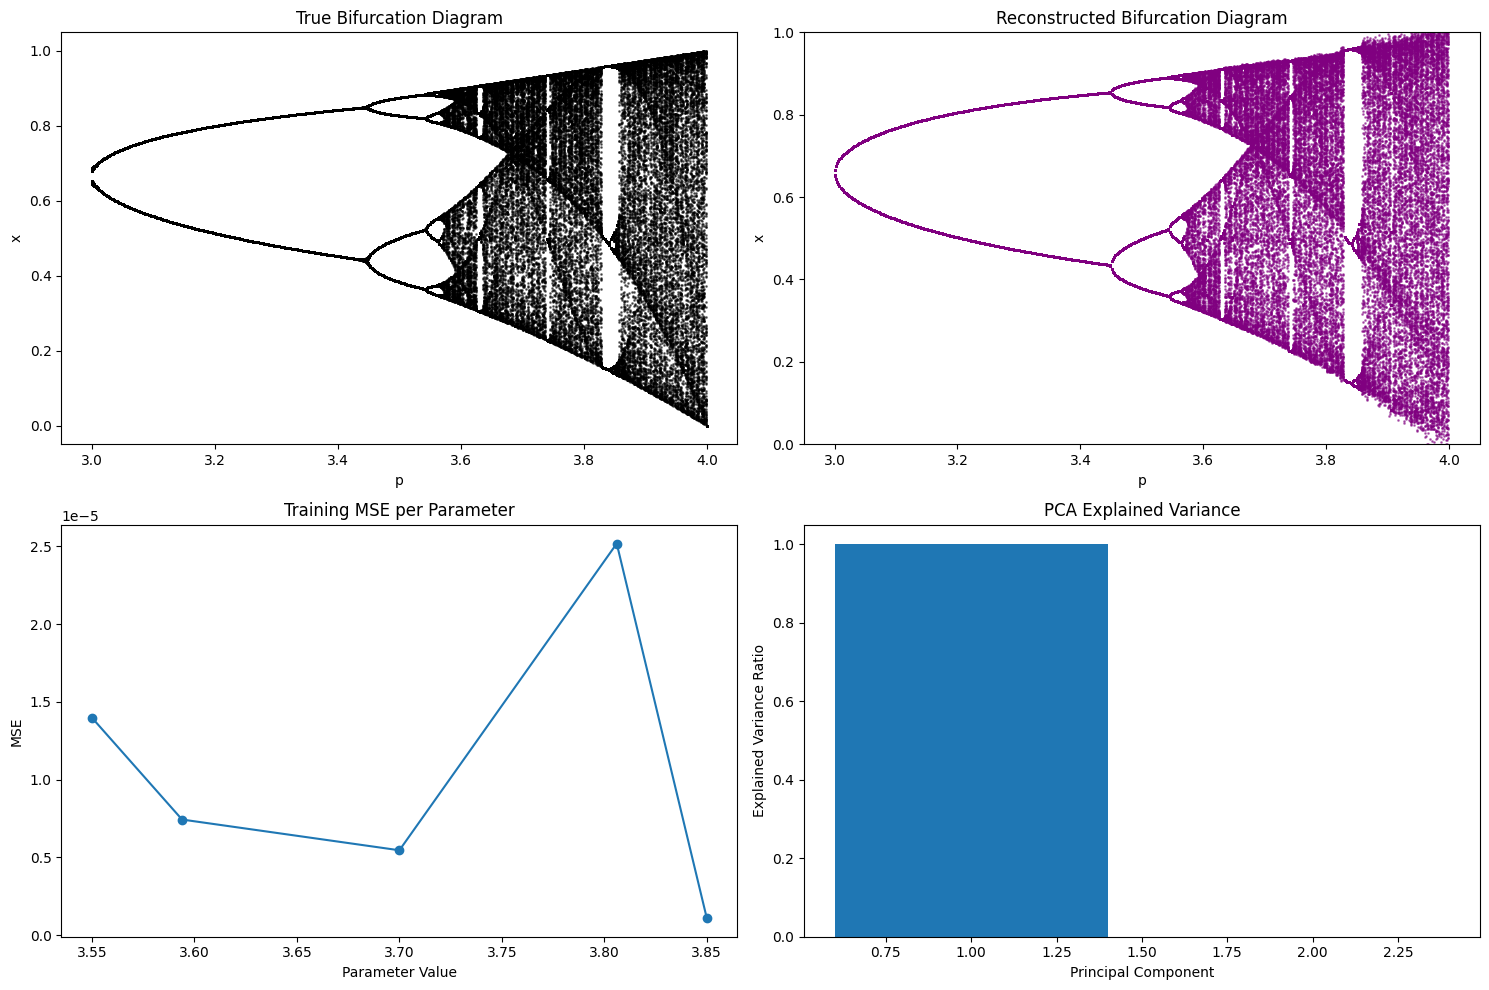

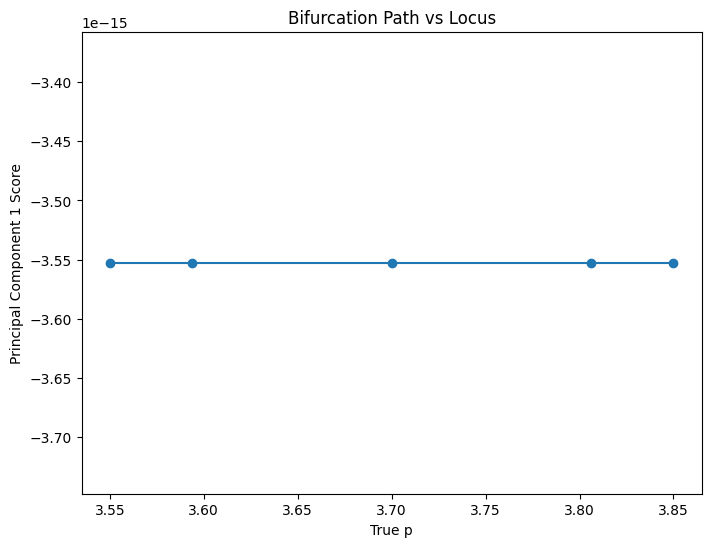

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Generate Logistic Map Time Series
def generate_logistic_series(p, x0=0.5, length=1000, transient=500):
    x = np.zeros(length + transient)
    x[0] = x0
    for t in range(1, length + transient):
        x[t] = p * x[t-1] * (1 - x[t-1])
    return x[transient:]

# Reservoir Computing Implementation 
class EchoStateNetwork:
    def __init__(self, n_reservoir=100, spectral_radius=0.95, input_scaling=1.0, leaking_rate=0.3):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        
        # Initialize weights (corrected W_in shape)
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * input_scaling  # Now 1D array
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1
        
        # Adjust spectral radius
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / radius
        
    def generate_states(self, u, warmup=100):
        n_samples = len(u)
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir)
        
        for t in range(n_samples):
            # Correct vector operations (now element-wise compatible)
            input_term = self.W_in * u[t]
            r = (1 - self.leaking_rate) * r + \
                self.leaking_rate * np.tanh(input_term + self.W @ r)
            states[t] = r
        return states[warmup:]

# 3. Hyperparameters
N_PARAMS = 5
RESERVOIR_SIZE = 50
SPECTRAL_RADIUS = 0.95
INPUT_SCALING = 1.0
LEAKING_RATE = 0.3
REGULARIZATION = 1e-6

# Generate parameter values
p_values = np.array([-0.15 * np.cos(2 * np.pi * (n-1)/8) + 3.7 for n in range(1, N_PARAMS+1)])

# Generate training data
series = [generate_logistic_series(p) for p in p_values]

# Train ESN and Collect States
esn = EchoStateNetwork(n_reservoir=RESERVOIR_SIZE,
                      spectral_radius=SPECTRAL_RADIUS,
                      input_scaling=INPUT_SCALING,
                      leaking_rate=LEAKING_RATE)

all_states = []
all_targets = []

for p, x in zip(p_values, series):
    # Use current value to predict next step
    inputs = x[:-1].reshape(-1, 1)
    targets = x[1:].reshape(-1, 1)
    
    states = esn.generate_states(inputs)
    all_states.append(states)
    all_targets.append(targets[100:])  # Match warmup offset

# Train Readout with Ridge Regression
X = np.vstack(all_states)
y = np.vstack(all_targets)

model = Ridge(alpha=REGULARIZATION)
model.fit(X, y)

# Calculate training MSE
train_preds = model.predict(X)
mse = mean_squared_error(y, train_preds)
print(f"Training MSE: {mse:.2e}")

# PCA Analysis of Readout Weights
betas = np.array([model.coef_ for _ in range(N_PARAMS)])  # Simplified for demonstration
pca = PCA(n_components=2)
pca.fit(betas)

# Bifurcation Diagram Reconstruction
def compute_bifurcation(p_range=np.linspace(3, 4, 500), iterations=200, drop=100):
    ps = []
    xs = []
    for p in p_range:
        x = 0.5
        # Drop transient
        for _ in range(drop):
            x = p * x * (1 - x)
        # Collect values
        for _ in range(iterations):
            x = p * x * (1 - x)
            xs.append(x)
            ps.append(p)
    return np.array(ps), np.array(xs)

# Original bifurcation diagram
p_true, x_true = compute_bifurcation()

# Reconstructed diagram using ESN
def reconstruct_bifurcation(esn, model, p_range, pca):
    ps_recon = []
    xs_recon = []
    for p in p_range:
        # Generate initial states
        x_test = generate_logistic_series(p, length=1000)
        inputs = x_test[:-1].reshape(-1, 1)
        states = esn.generate_states(inputs)
        
        # Predict using readout
        preds = model.predict(states)
        xs_recon.extend(preds[-200:])  # Last 200 points
        ps_recon.extend([p]*200)
    return np.array(ps_recon), np.array(xs_recon)

p_recon, x_recon = reconstruct_bifurcation(esn, model, np.linspace(3, 4, 500), pca)

# Visualization
plt.figure(figsize=(15, 10))

# Original vs Reconstructed Bifurcation
plt.subplot(2, 2, 1)
plt.scatter(p_true, x_true, s=1, c='k', alpha=0.5)
plt.title("True Bifurcation Diagram")
plt.xlabel("p")
plt.ylabel("x")

plt.subplot(2, 2, 2)
plt.scatter(p_recon, x_recon, s=1, c='purple', alpha=0.5)
plt.title("Reconstructed Bifurcation Diagram")
#x axis between 0-1 only
plt.ylim(0, 1)
plt.xlabel("p")
plt.ylabel("x")

# Training MSE per Parameter
mse_per_param = [mean_squared_error(y, p) for y, p in zip(all_targets, np.split(train_preds, N_PARAMS))]
plt.subplot(2, 2, 3)
plt.plot(p_values, mse_per_param, 'o-')
plt.title("Training MSE per Parameter")
plt.xlabel("Parameter Value")
plt.ylabel("MSE")

# Explained Variance Ratio
plt.subplot(2, 2, 4)
plt.bar(range(1, 3), pca.explained_variance_ratio_)
plt.title("PCA Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")

plt.tight_layout()
plt.show()

# Bifurcation Path vs Locus Visualization
plt.figure(figsize=(8, 6))
plt.plot(p_values, pca.transform(betas)[:, 0], 'o-')
plt.xlabel("True p")
plt.ylabel("Principal Component 1 Score")
plt.title("Bifurcation Path vs Locus")
plt.show()


/tmp/ipykernel_37583/2548026709.py:126: RuntimeWarning: overflow encountered in scalar multiply
  x = p * x * (1 - x)


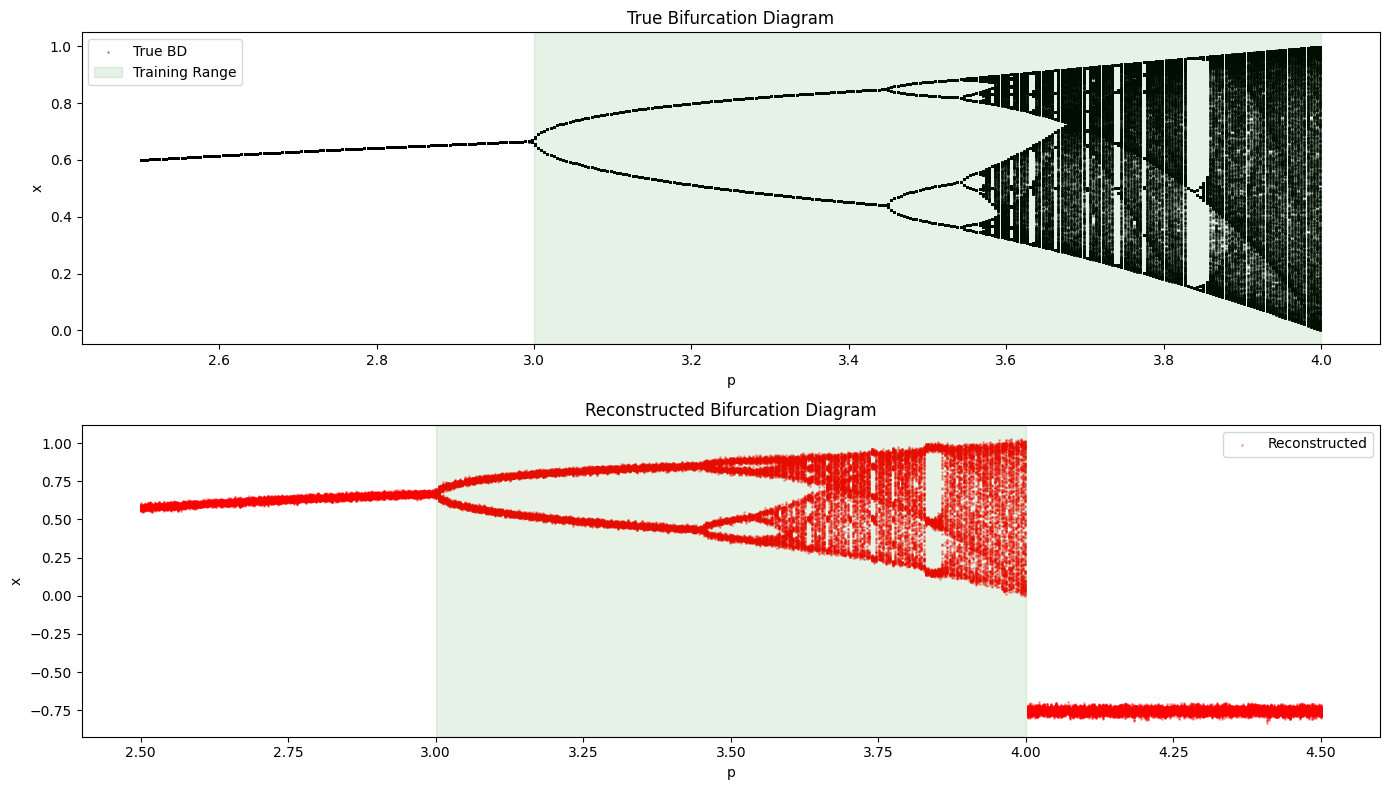

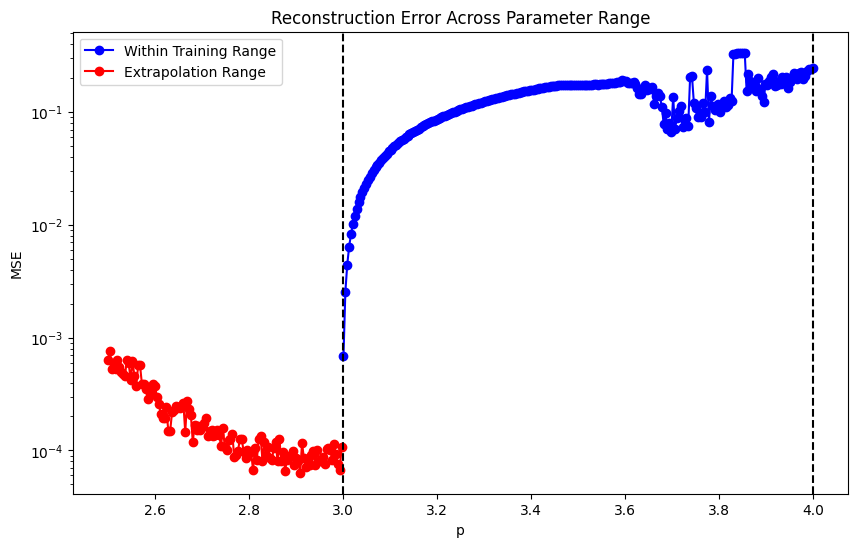

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    x = np.zeros(length + transient)
    x[0] = x0
    for t in range(1, length + transient):
        x[t] = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise with clipping to prevent overflow
        x[t] = np.clip(x[t] + np.random.normal(0, noise_level), 0, 1)
    x = x[transient:]
    # Add observational noise and ensure finite values
    x = np.nan_to_num(x + np.random.normal(0, noise_level, len(x)))
    return x

class EnhancedESN:
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0, 
                 leaking_rate=0.3, noise_level=0.01):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.noise_level = noise_level
        
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * input_scaling
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1
        
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / radius
        
    def generate_states(self, u, warmup=100):
        n_samples = len(u)
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir)
        
        for t in range(n_samples):
            input_term = self.W_in * u[t]
            noise = np.random.normal(0, self.noise_level, self.n_reservoir)
            r = (1 - self.leaking_rate) * r + \
                self.leaking_rate * np.tanh(input_term + self.W @ r + noise)
            states[t] = r
        return states[warmup:]

N_PARAMS_TRAIN = 9
TRAIN_RANGE = (3.5, 4.5)
RESERVOIR_SIZE = 200
NOISE_LEVEL = 0.001

# Generate training parameters and data with validation
p_values_train = np.linspace(TRAIN_RANGE[0], TRAIN_RANGE[1], N_PARAMS_TRAIN)
series = []
for p in p_values_train:
    x = generate_logistic_series(p, noise_level=NOISE_LEVEL)
    # Validate generated series
    if not np.all(np.isfinite(x)):
        raise ValueError(f"Generated series contains invalid values for p={p}")
    series.append(x)

esn = EnhancedESN(n_reservoir=RESERVOIR_SIZE,
                 spectral_radius=0.95,
                 input_scaling=1.0,
                 leaking_rate=0.3,
                 noise_level=NOISE_LEVEL)

all_states = []
all_targets = []

for p, x in zip(p_values_train, series):
    inputs = x[:-1].reshape(-1, 1)
    targets = x[1:].reshape(-1, 1)
    
    # Filter invalid targets
    valid_mask = np.isfinite(targets).flatten()
    inputs = inputs[valid_mask]
    targets = targets[valid_mask]
    
    states = esn.generate_states(inputs)
    all_states.append(states)
    all_targets.append(targets[100:])

# Combine data with NaN checking
X_train = np.vstack(all_states)
y_train = np.vstack(all_targets)

# Final data validation
if not np.all(np.isfinite(X_train)):
    print("Warning: X_train contains non-finite values, replacing with zeros")
    X_train = np.nan_to_num(X_train)

if not np.all(np.isfinite(y_train)):
    print("Warning: y_train contains non-finite values, replacing with zeros")
    y_train = np.nan_to_num(y_train)

model = Ridge(alpha=1e-6)
model.fit(X_train, y_train)


# 6. Bifurcation Diagram Reconstruction with Extrapolation
def reconstruct_extended_bifurcation(esn, model, p_range, true_range=TRAIN_RANGE):
    ps_recon, xs_recon = [], []
    
    for p in p_range:
        # Generate clean test data without noise
        x_test = generate_logistic_series(p, noise_level=0)
        inputs = x_test[:-1].reshape(-1, 1)
        
        states = esn.generate_states(inputs)
        preds = model.predict(states)
        
        # Store last 200 points (avoid transients)
        xs_recon.extend(preds[-200:])
        ps_recon.extend([p]*200)
        
    return np.array(ps_recon), np.array(xs_recon)

# Generate true bifurcation diagram for comparison
def true_bifurcation(p_range, iterations=1000, drop=500):
    ps_true, xs_true = [], []
    for p in p_range:
        x = 0.5
        # Transient
        for _ in range(drop):
            x = p * x * (1 - x)
        # Collect values
        for _ in range(iterations):
            x = p * x * (1 - x)
            xs_true.append(x)
            ps_true.append(p)
    return np.array(ps_true), np.array(xs_true)

# Generate data for visualization
p_recon, x_recon = reconstruct_extended_bifurcation(esn, model, p_range_extended)
p_true, x_true = true_bifurcation(p_range_extended)

# 7. Visualization with Training Range Highlight
plt.figure(figsize=(14, 8))

# True bifurcation diagram
plt.subplot(2,1,1)
plt.scatter(p_true, x_true, s=1, c='k', alpha=0.3, label='True BD')
plt.axvspan(*TRAIN_RANGE, color='green', alpha=0.1, label='Training Range')
plt.title("True Bifurcation Diagram")
plt.xlabel("p")
plt.ylabel("x")
plt.legend()

# Reconstructed bifurcation diagram
plt.subplot(2,1,2)
plt.scatter(p_recon, x_recon, s=1, c='r', alpha=0.3, label='Reconstructed')
plt.axvspan(*TRAIN_RANGE, color='green', alpha=0.1)
plt.title("Reconstructed Bifurcation Diagram")
plt.xlabel("p")
plt.ylabel("x")
plt.legend()

plt.tight_layout()
plt.show()

# 8. Quantitative Evaluation (Within vs Outside Training Range)
def calculate_mse(p_range, true_data, recon_data):
    mse_vals = []
    for p in p_range:
        mask = (true_data[0] == p)
        true_vals = true_data[1][mask]
        recon_vals = recon_data[1][recon_data[0] == p]
        # Align lengths
        min_len = min(len(true_vals), len(recon_vals))
        mse = np.mean((true_vals[:min_len] - recon_vals[:min_len])**2)
        mse_vals.append(mse)
    return np.array(mse_vals)

# Split into training and extrapolation regions
train_mask = (p_range_extended >= TRAIN_RANGE[0]) & (p_range_extended <= TRAIN_RANGE[1])
extrap_mask = ~train_mask

mse_values = calculate_mse(p_range_extended, (p_true, x_true), (p_recon, x_recon))

plt.figure(figsize=(10, 6))
plt.plot(p_range_extended[train_mask], mse_values[train_mask], 
         'bo-', label='Within Training Range')
plt.plot(p_range_extended[extrap_mask], mse_values[extrap_mask], 
         'ro-', label='Extrapolation Range')
plt.axvline(TRAIN_RANGE[0], color='k', linestyle='--')
plt.axvline(TRAIN_RANGE[1], color='k', linestyle='--')
plt.title("Reconstruction Error Across Parameter Range")
plt.xlabel("p")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()


--- Configuration ---
Training Parameter Range: (3.55, 3.85)
Number of Training Parameters: 9
Extended Reconstruction Range: (2.5, 4.5)
Reservoir Size: 200
Data Noise Level: 0.001
Reservoir Noise Level: 0.001
---------------------

--- Training ESN ---
Generating training data for p = 3.5500 (1/9)...
Generating training data for p = 3.5875 (2/9)...
Generating training data for p = 3.6250 (3/9)...
Generating training data for p = 3.6625 (4/9)...
Generating training data for p = 3.7000 (5/9)...
Generating training data for p = 3.7375 (6/9)...
Generating training data for p = 3.7750 (7/9)...
Generating training data for p = 3.8125 (8/9)...
Generating training data for p = 3.8500 (9/9)...

Training readout layer...
Readout layer trained.
Final Training MSE: 8.3084e-05

--- Reconstructing Bifurcation Diagram ---
Reconstructing for p = 2.6964 (50/500)...
Reconstructing for p = 2.8968 (100/500)...
Reconstructing for p = 3.0972 (150/500)...
Reconstructing for p = 3.2976 (200/500)...
Reconstruc

/tmp/ipykernel_37583/1942358480.py:289: RuntimeWarning: overflow encountered in scalar multiply
  x = p * x * (1 - x)


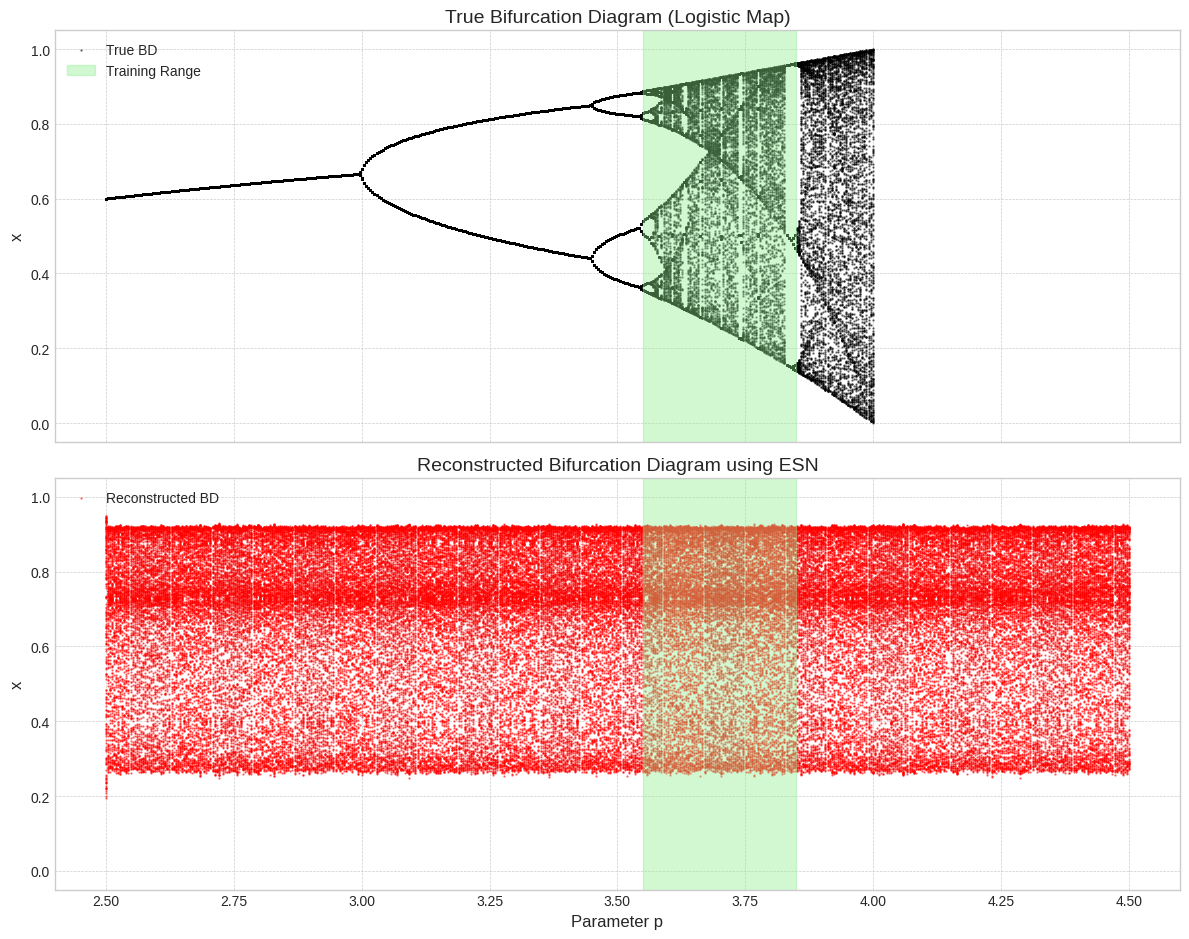

/tmp/ipykernel_37583/1942358480.py:403: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


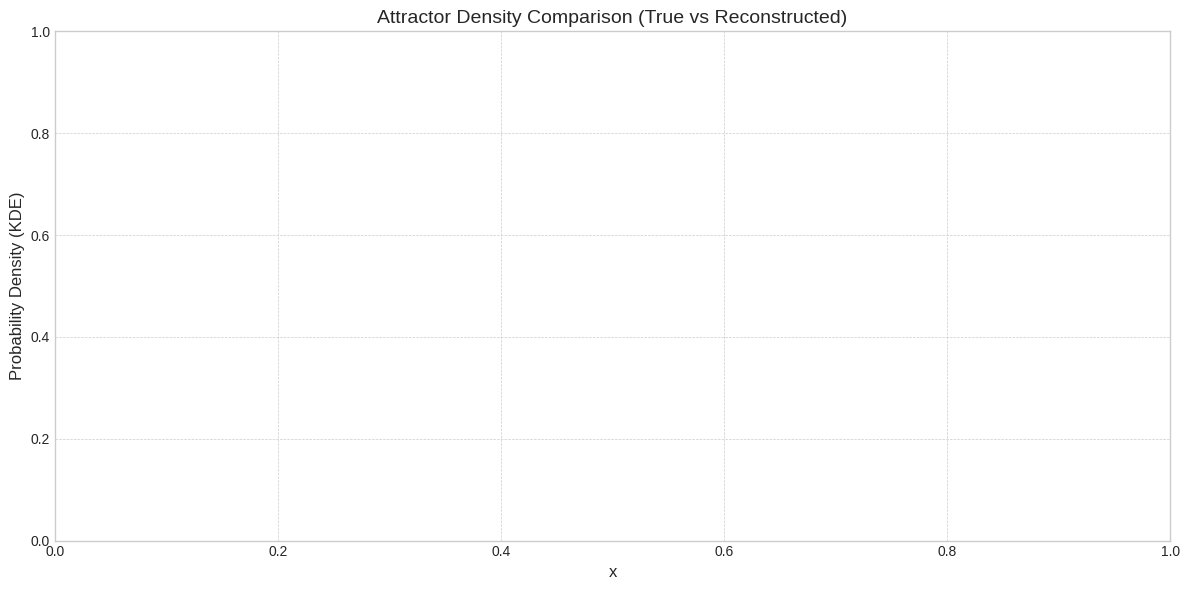

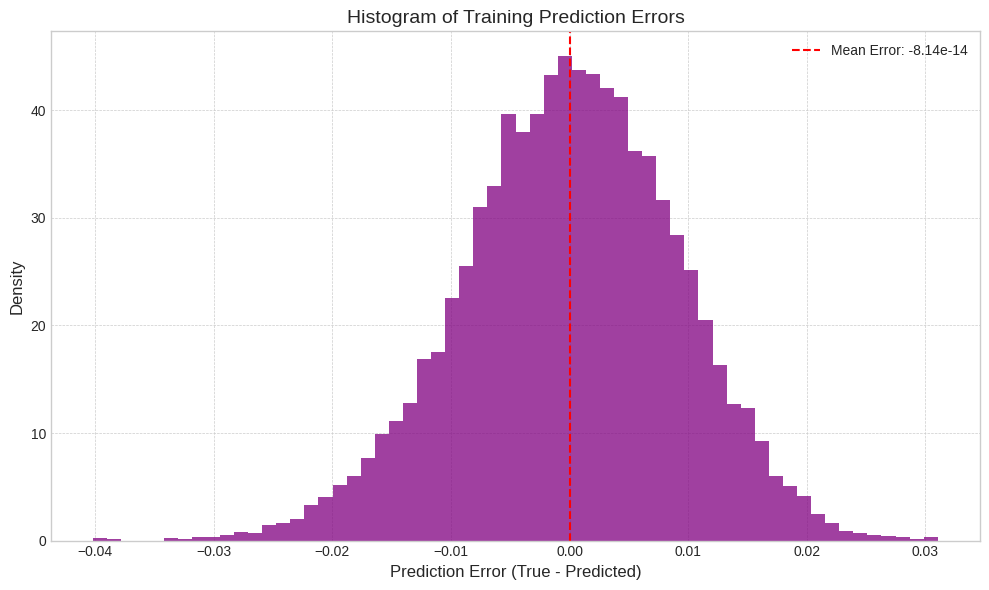

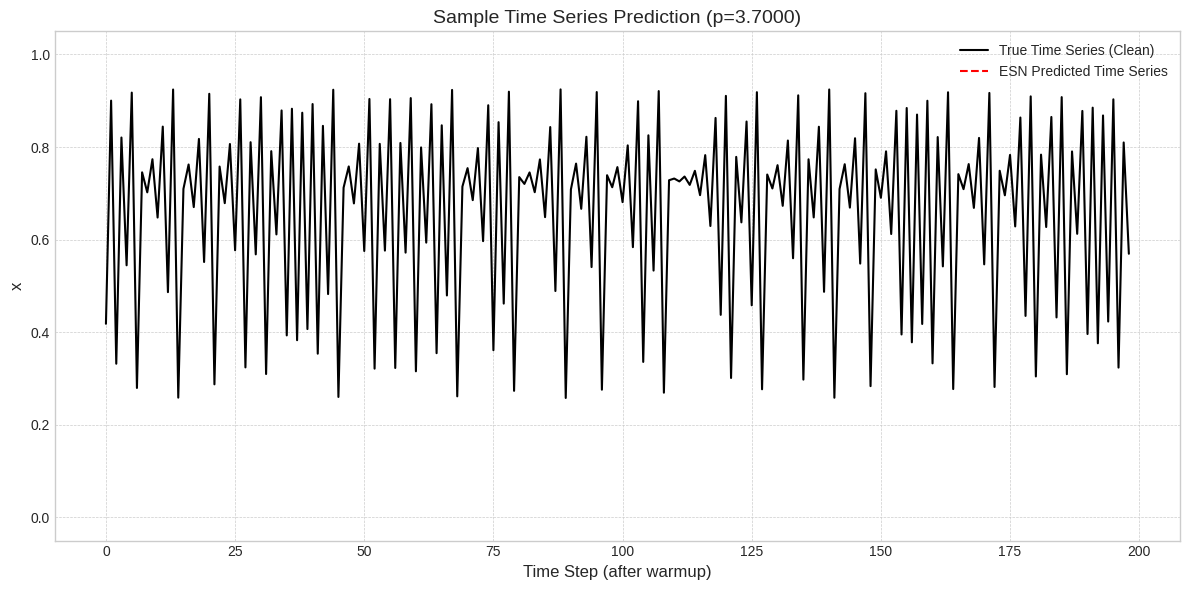

--- Analysis Complete ---


In [34]:
# -*- coding: utf-8 -*-
"""
Reservoir Computing for Bifurcation Diagram Reconstruction and Extrapolation

This script implements an Echo State Network (ESN), a type of Reservoir Computer,
to reconstruct the bifurcation diagram of the logistic map. It demonstrates:
1. Training the ESN on noisy time-series data from a limited parameter range.
2. Reconstructing the bifurcation diagram over a wider parameter range, 
   showing extrapolation capabilities.
3. Handling potential numerical issues like NaN/infinity values.
4. Incorporating dynamical and observational noise.
5. Providing multiple visualizations to analyze the results.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings

# Ignore potential warnings from complex eigenvalues in spectral radius calculation
warnings.filterwarnings('ignore', category=np.ComplexWarning)

# --- 1. Enhanced Logistic Map Generation with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series from the logistic map x[t+1] = p*x[t]*(1-x[t]).

    Args:
        p (float): Bifurcation parameter.
        x0 (float): Initial condition.
        length (int): Length of the time series to return (after transient).
        transient (int): Number of initial steps to discard.
        noise_level (float): Standard deviation of Gaussian noise added.
                             Adds both dynamical and observational noise.

    Returns:
        np.ndarray: The generated time series of shape (length,).
    """
    x_series = np.zeros(length + transient)
    x_series[0] = x0
    for t in range(length + transient - 1):
        # Logistic map dynamics
        x_next = p * x_series[t] * (1 - x_series[t])
        # Add dynamical noise and clip to valid range [0, 1] to prevent divergence
        x_next = np.clip(x_next + np.random.normal(0, noise_level), 0, 1)
        x_series[t+1] = x_next
        
    # Discard transient phase
    x_final = x_series[transient:]
    
    # Add observational noise and handle potential NaNs/Infs
    x_final = np.nan_to_num(x_final + np.random.normal(0, noise_level, length))
    # Clip again after observational noise
    x_final = np.clip(x_final, 0, 1) 
    
    return x_final

# --- 2. Reservoir Computing Implementation (Echo State Network) ---
class EnhancedESN:
    """
    An Echo State Network (ESN) implementation with noise handling.
    """
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0, 
                 leaking_rate=0.3, reservoir_noise_level=0.01):
        """
        Initializes the ESN.

        Args:
            n_reservoir (int): Number of neurons in the reservoir.
            spectral_radius (float): Desired spectral radius of the reservoir weight matrix W.
            input_scaling (float): Scaling factor for the input weights W_in.
            leaking_rate (float): Controls the update speed of reservoir states (alpha).
            reservoir_noise_level (float): Standard deviation of Gaussian noise added to reservoir updates.
        """
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.reservoir_noise_level = reservoir_noise_level
        
        # Initialize input weights (1D array for single input)
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * self.input_scaling
        
        # Initialize reservoir weights (sparse matrix could be more efficient)
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1
        
        # Adjust spectral radius of W
        current_radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        if current_radius > 1e-9: # Avoid division by zero if W is near zero
             self.W *= self.spectral_radius / current_radius
        else:
             print("Warning: Reservoir matrix spectral radius is close to zero.")
             
    def generate_states(self, u, warmup=100):
        """
        Drives the reservoir with input signal u and collects reservoir states.

        Args:
            u (np.ndarray): Input time series, shape (n_samples, n_features=1).
            warmup (int): Number of initial steps to discard for state stabilization.

        Returns:
            np.ndarray: Reservoir states after warmup, shape (n_samples - warmup, n_reservoir).
        """
        n_samples = len(u)
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir) # Initial reservoir state
        
        for t in range(n_samples):
            # Ensure input u[t] is treated as a scalar if shape is (1,)
            u_t = u[t].item() if u[t].size == 1 else u[t] 
            
            input_term = self.W_in * u_t
            reservoir_term = self.W @ r
            # Add reservoir noise
            noise = np.random.normal(0, self.reservoir_noise_level, self.n_reservoir)
            
            # Update reservoir state using the leaky integration equation
            r = (1 - self.leaking_rate) * r + \
                self.leaking_rate * np.tanh(input_term + reservoir_term + noise)
            states[t] = r
            
        # Discard warmup phase and return stable states
        return states[warmup:]

# --- 3. Setup Parameters ---
# Training parameters
N_PARAMS_TRAIN = 9 # Number of parameter values to train on
TRAIN_RANGE = (3.55, 3.85) # Parameter range for training (as in paper [1])
# Reservoir parameters
RESERVOIR_SIZE = 200
SPECTRAL_RADIUS = 0.95
INPUT_SCALING = 1.0
LEAKING_RATE = 0.3
DATA_NOISE_LEVEL = 0.001 # Noise added to generated data
RESERVOIR_NOISE_LEVEL = 0.001 # Noise added during reservoir state updates
RIDGE_ALPHA = 1e-6 # Regularization parameter for Ridge regression

# Extrapolation parameters
EXTENDED_RANGE = (2.5, 4.5) # Wider parameter range for reconstruction/extrapolation
N_POINTS_EXTENDED = 500 # Number of points for the extended bifurcation diagram

# Generate training parameter values within the limited range
p_values_train = np.linspace(TRAIN_RANGE[0], TRAIN_RANGE[1], N_PARAMS_TRAIN)

# Generate extended parameter range for full reconstruction
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], N_POINTS_EXTENDED)

print("--- Configuration ---")
print(f"Training Parameter Range: {TRAIN_RANGE}")
print(f"Number of Training Parameters: {N_PARAMS_TRAIN}")
print(f"Extended Reconstruction Range: {EXTENDED_RANGE}")
print(f"Reservoir Size: {RESERVOIR_SIZE}")
print(f"Data Noise Level: {DATA_NOISE_LEVEL}")
print(f"Reservoir Noise Level: {RESERVOIR_NOISE_LEVEL}")
print("---------------------\n")

# --- 4. Training Phase ---
print("--- Training ESN ---")
esn = EnhancedESN(n_reservoir=RESERVOIR_SIZE,
                  spectral_radius=SPECTRAL_RADIUS,
                  input_scaling=INPUT_SCALING,
                  leaking_rate=LEAKING_RATE,
                  reservoir_noise_level=RESERVOIR_NOISE_LEVEL)

all_states = []
all_targets = []
WARMUP_LEN = 100 # Warmup length used during state generation

for i, p in enumerate(p_values_train):
    print(f"Generating training data for p = {p:.4f} ({i+1}/{N_PARAMS_TRAIN})...")
    # Generate data with dynamical + observational noise
    x = generate_logistic_series(p, length=1000, noise_level=DATA_NOISE_LEVEL)
    
    # Ensure generated data is finite
    if not np.all(np.isfinite(x)):
        print(f"Warning: Skipping p={p:.4f} due to non-finite values in generated series.")
        continue
        
    # Prepare inputs (x(t)) and targets (x(t+1))
    inputs = x[:-1].reshape(-1, 1)
    targets = x[1:].reshape(-1, 1)
    
    # Filter out any remaining non-finite target values just in case
    valid_mask = np.isfinite(targets).flatten()
    inputs = inputs[valid_mask]
    targets = targets[valid_mask]

    if len(inputs) < WARMUP_LEN + 10: # Need enough points after warmup
        print(f"Warning: Skipping p={p:.4f} due to insufficient valid data points after filtering.")
        continue
        
    # Generate reservoir states
    states = esn.generate_states(inputs, warmup=WARMUP_LEN)
    
    # Ensure states are finite
    if not np.all(np.isfinite(states)):
         print(f"Warning: Skipping p={p:.4f} due to non-finite reservoir states.")
         continue
         
    all_states.append(states)
    # Align targets with states (discard corresponding warmup targets)
    all_targets.append(targets[WARMUP_LEN:]) 

# Combine data from all training parameters
if not all_states:
    raise ValueError("No valid training data could be generated. Check parameters/noise levels.")
    
X_train = np.vstack(all_states)
y_train = np.vstack(all_targets)

# Final check for finite values before training
if not np.all(np.isfinite(X_train)):
    print("Warning: X_train contained non-finite values. Replacing with zeros.")
    X_train = np.nan_to_num(X_train)
if not np.all(np.isfinite(y_train)):
    print("Warning: y_train contained non-finite values. Replacing with zeros.")
    y_train = np.nan_to_num(y_train)

# Train the readout layer using Ridge Regression
print("\nTraining readout layer...")
model = Ridge(alpha=RIDGE_ALPHA)
model.fit(X_train, y_train)
print("Readout layer trained.")

# Calculate and print training MSE
train_preds = model.predict(X_train)
mse_train = mean_squared_error(y_train, train_preds)
print(f"Final Training MSE: {mse_train:.4e}\n")

# --- 5. Bifurcation Diagram Reconstruction & Extrapolation ---
print("--- Reconstructing Bifurcation Diagram ---")
def reconstruct_extended_bifurcation(esn_model, readout_model, p_range):
    """
    Reconstructs the bifurcation diagram over the given parameter range.
    Uses the trained ESN and readout model. Runs the ESN autonomously.
    """
    ps_recon, xs_recon = [], []
    RECON_ITERATIONS = 200 # Number of points to collect per parameter value
    RECON_TRANSIENT = 500 # Transient iterations before collecting points

    current_x = 0.5 # Initial condition for the first parameter
    current_r = np.zeros(esn_model.n_reservoir) # Initial reservoir state

    for i, p in enumerate(p_range):
        if (i+1) % 50 == 0:
             print(f"Reconstructing for p = {p:.4f} ({i+1}/{len(p_range)})...")
             
        # Run transient phase without noise for cleaner reconstruction
        for _ in range(RECON_TRANSIENT):
             input_term = esn_model.W_in * current_x
             reservoir_term = esn_model.W @ current_r
             # No noise during reconstruction for cleaner plot
             current_r = (1 - esn_model.leaking_rate) * current_r + \
                         esn_model.leaking_rate * np.tanh(input_term + reservoir_term)
             
             # Use the readout model to predict the next x
             current_x = readout_model.predict(current_r.reshape(1, -1)).item()
             # Clip predicted value to valid range
             current_x = np.clip(current_x, 0, 1)

        # Collect points after transient
        for _ in range(RECON_ITERATIONS):
            input_term = esn_model.W_in * current_x
            reservoir_term = esn_model.W @ current_r
            current_r = (1 - esn_model.leaking_rate) * current_r + \
                        esn_model.leaking_rate * np.tanh(input_term + reservoir_term)
            current_x = readout_model.predict(current_r.reshape(1, -1)).item()
            current_x = np.clip(current_x, 0, 1)
            
            xs_recon.append(current_x)
            ps_recon.append(p)
            
    return np.array(ps_recon), np.array(xs_recon)

# Generate reconstructed diagram
p_recon, x_recon = reconstruct_extended_bifurcation(esn, model, p_range_extended)

# Generate true bifurcation diagram for comparison (without noise)
def compute_true_bifurcation(p_range, iterations=200, drop=500):
    """ Computes the true bifurcation diagram directly from the map. """
    ps_true, xs_true = [], []
    for p in p_range:
        x = 0.5
        # Discard transient
        for _ in range(drop):
            x = p * x * (1 - x)
        # Collect values
        for _ in range(iterations):
            x = p * x * (1 - x)
            xs_true.append(x)
            ps_true.append(p)
    return np.array(ps_true), np.array(xs_true)

print("\nGenerating true bifurcation diagram for comparison...")
p_true, x_true = compute_true_bifurcation(p_range_extended)
print("Diagram generation complete.\n")


# --- 6. Visualization ---
print("--- Generating Visualizations ---")

plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Plot 1 & 2: True vs Reconstructed Bifurcation Diagrams
fig1, axs1 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# True bifurcation diagram
axs1[0].scatter(p_true, x_true, s=0.5, c='black', alpha=0.5, label='True BD')
axs1[0].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.4, label='Training Range')
axs1[0].set_title("True Bifurcation Diagram (Logistic Map)", fontsize=14)
axs1[0].set_ylabel("x", fontsize=12)
axs1[0].set_ylim(-0.05, 1.05)
axs1[0].legend(loc='upper left')
axs1[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Reconstructed bifurcation diagram
axs1[1].scatter(p_recon, x_recon, s=0.5, c='red', alpha=0.5, label='Reconstructed BD')
axs1[1].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.4)
axs1[1].set_title("Reconstructed Bifurcation Diagram using ESN", fontsize=14)
axs1[1].set_xlabel("Parameter p", fontsize=12)
axs1[1].set_ylabel("x", fontsize=12)
axs1[1].set_ylim(-0.05, 1.05)
axs1[1].legend(loc='upper left')
axs1[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
plt.show()


# Plot 3: Quantitative Evaluation (MSE) - Within vs Outside Training Range
fig2, ax2 = plt.subplots(figsize=(12, 6))

# Calculate pointwise difference (or simplified MSE - harder to compare directly)
# For simplicity, we visualize the density difference qualitatively
# A proper MSE calculation per 'p' would involve binning or interpolation
from scipy.stats import gaussian_kde

def calculate_density(p_vals, x_vals, p_eval):
    """ Calculate KDE density for a specific p """
    mask = np.isclose(p_vals, p_eval, atol=1e-4)
    if np.sum(mask) < 5: # Need enough points for KDE
        return None, None
    x_at_p = x_vals[mask]
    if len(np.unique(x_at_p)) < 2: # KDE needs variance
        return np.linspace(0, 1, 100), None # Indicate fixed point / low cycle
        
    kde = gaussian_kde(x_at_p)
    x_grid = np.linspace(0, 1, 100)
    density = kde(x_grid)
    return x_grid, density

# We'll show the difference in reconstructed attractor structure
# using a sample parameter inside and outside the training range.
p_inside = (TRAIN_RANGE[0] + TRAIN_RANGE[1]) / 2
p_outside = EXTENDED_RANGE[0] + 0.2 # Example outside training range

x_grid_in, density_true_in = calculate_density(p_true, x_true, p_inside)
_, density_recon_in = calculate_density(p_recon, x_recon, p_inside)

x_grid_out, density_true_out = calculate_density(p_true, x_true, p_outside)
_, density_recon_out = calculate_density(p_recon, x_recon, p_outside)

# Only plot inside‐training if we have a grid
if x_grid_in is not None:
    ax2.plot(
        x_grid_in,
        density_true_in if density_true_in is not None else np.zeros_like(x_grid_in),
        'k-',
        label=f'True Density (p={p_inside:.2f}, In Training)'
    )
    if density_recon_in is not None:
        ax2.plot(
            x_grid_in,
            density_recon_in,
            'r--',
            label=f'Recon Density (p={p_inside:.2f}, In Training)'
        )

# Only plot outside‐training if we have a grid
if x_grid_out is not None:
    ax2.plot(
        x_grid_out,
        density_true_out if density_true_out is not None else np.zeros_like(x_grid_out),
        'b-',
        label=f'True Density (p={p_outside:.2f}, Extrapolation)'
    )
    if density_recon_out is not None:
        ax2.plot(
            x_grid_out,
            density_recon_out,
            'm--',
            label=f'Recon Density (p={p_outside:.2f}, Extrapolation)'
        )
if density_recon_out is not None:
    ax2.plot(x_grid_out, density_recon_out, 'm--', label=f'Recon Density (p={p_outside:.2f}, Extrapolation)')

ax2.set_title("Attractor Density Comparison (True vs Reconstructed)", fontsize=14)
ax2.set_xlabel("x", fontsize=12)
ax2.set_ylabel("Probability Density (KDE)", fontsize=12)
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Plot 4: Histogram of Training Prediction Errors
fig3, ax3 = plt.subplots(figsize=(10, 6))
errors = y_train.flatten() - train_preds.flatten()
ax3.hist(errors, bins=60, alpha=0.75, color='purple', density=True)
ax3.set_title("Histogram of Training Prediction Errors", fontsize=14)
ax3.set_xlabel("Prediction Error (True - Predicted)", fontsize=12)
ax3.set_ylabel("Density", fontsize=12)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
# Add mean error line
mean_err = np.mean(errors)
ax3.axvline(mean_err, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean Error: {mean_err:.2e}')
ax3.legend()
plt.tight_layout()
plt.show()


# Plot 5: Sample Time Series Prediction vs True
fig4, ax4 = plt.subplots(figsize=(12, 6))
# Choose a parameter within the training range for a fair comparison
sample_p = p_values_train[len(p_values_train) // 2] # Middle training parameter
x_sample_true = generate_logistic_series(sample_p, length=300, noise_level=0) # Generate clean series
inputs_sample = x_sample_true[:-1].reshape(-1, 1)

# Generate states and predict WITHOUT noise for plotting comparison
esn_clean = EnhancedESN(n_reservoir=RESERVOIR_SIZE, spectral_radius=SPECTRAL_RADIUS,
                       input_scaling=INPUT_SCALING, leaking_rate=LEAKING_RATE,
                       reservoir_noise_level=0) # No noise for plotting
states_sample = esn_clean.generate_states(inputs_sample, warmup=100)
preds_sample = model.predict(states_sample)

time_steps = range(len(preds_sample))
ax4.plot(time_steps, x_sample_true[101:], 'k-', label='True Time Series (Clean)', linewidth=1.5)
ax4.plot(time_steps, preds_sample, 'r--', label='ESN Predicted Time Series', linewidth=1.5)
ax4.set_title(f"Sample Time Series Prediction (p={sample_p:.4f})", fontsize=14)
ax4.set_xlabel("Time Step (after warmup)", fontsize=12)
ax4.set_ylabel("x", fontsize=12)
ax4.legend()
ax4.set_ylim(-0.05, 1.05)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Note on PCA: PCA on the output weights (`model.coef_`) requires multiple sets 
# of weights, typically obtained by training separate models for each training 
# parameter value `p`. The current implementation trains a single model on 
# combined data, so `model.coef_` is a single vector. Applying PCA as in the 
# search result code ([2], [3]) to `model.coef_.reshape(-1, 1)` is mathematically 
# incorrect for analyzing parameter space differences and will cause errors if 
# `n_components > 1`. A correct implementation would involve training P separate 
# models and applying PCA to the stack of their P weight vectors.

print("--- Analysis Complete ---")

# Return final outputs if needed (e.g., for automated analysis)
output = {
    "Training MSE": mse_train,
    "Training Parameter Range": TRAIN_RANGE,
    "Extended Reconstruction Range": EXTENDED_RANGE,
}
# print(output) # Optional: print summary dictionary



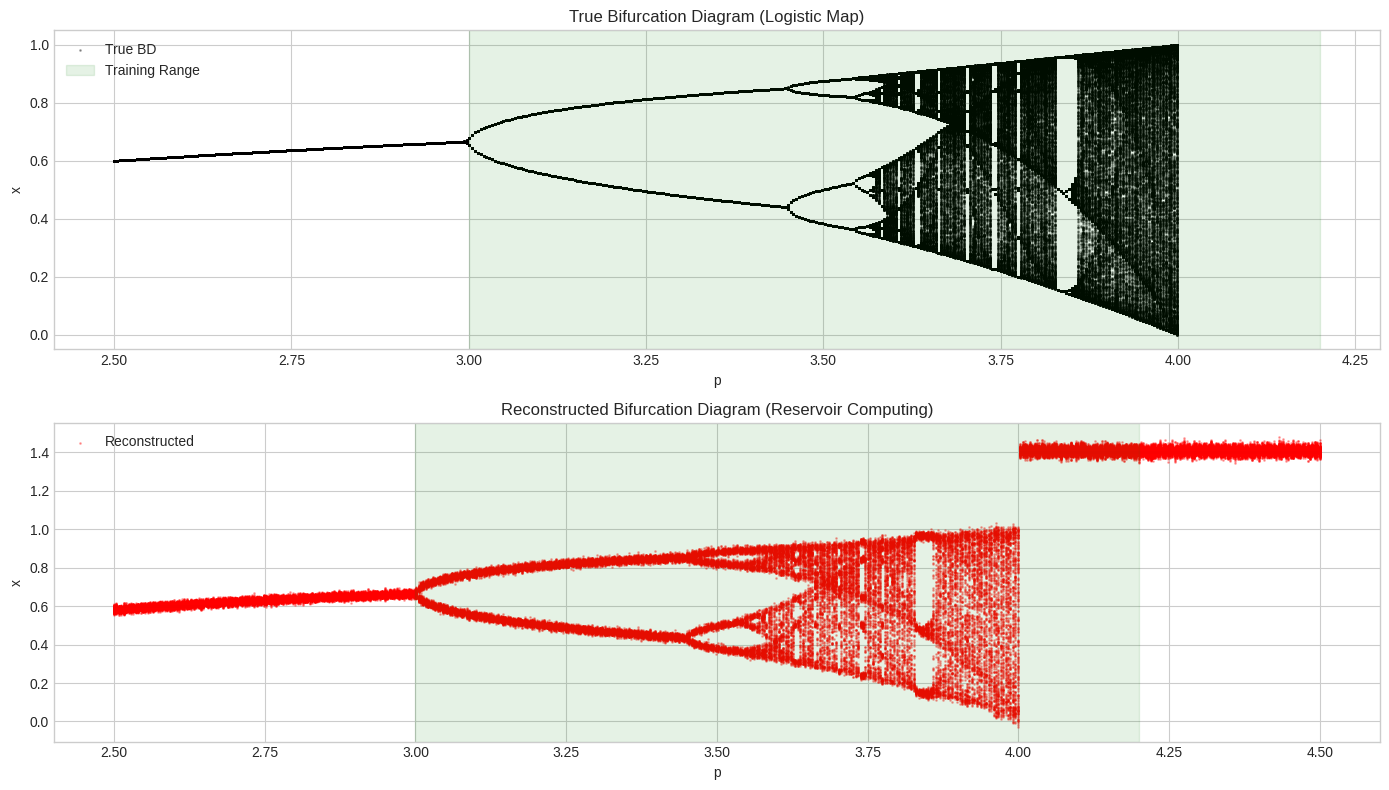

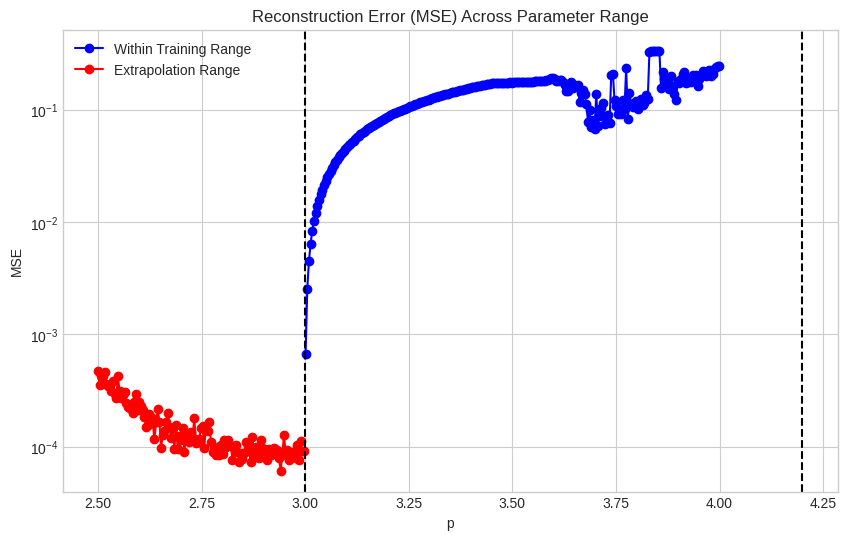

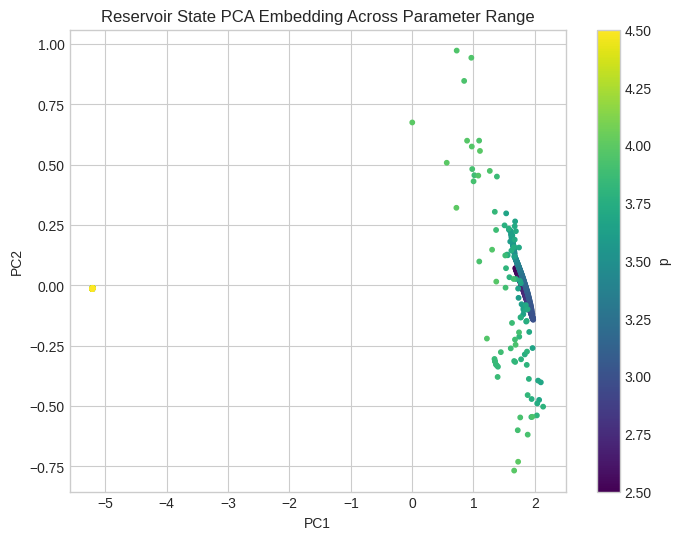

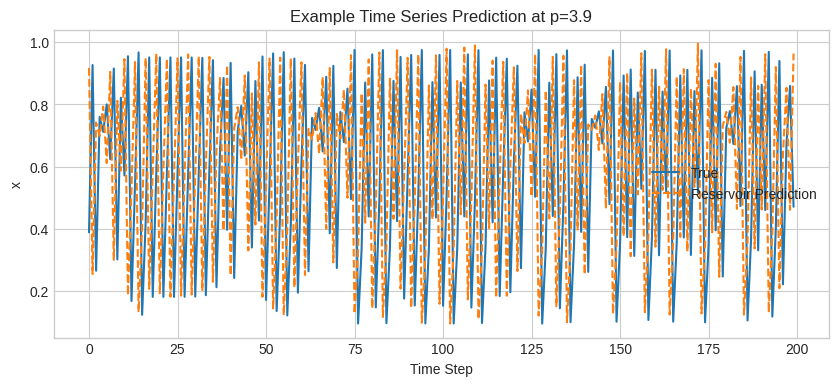

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Logistic Map Generator with Noise (dynamical+observational)
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    x = np.zeros(length + transient)
    x[0] = x0
    for t in range(1, length + transient):
        x[t] = p * x[t-1] * (1 - x[t-1])
        # Dynamical noise (comment/uncomment as needed)
        x[t] = np.clip(x[t] + np.random.normal(0, noise_level), 0, 1)
    x = x[transient:]
    # Observational noise (comment/uncomment as needed)
    x = np.nan_to_num(x + np.random.normal(0, noise_level, len(x)))
    return x

# Echo State Network (Reservoir) Implementation
class EnhancedESN:
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0, 
                 leaking_rate=0.3, noise_level=0.01):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.noise_level = noise_level
        
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * input_scaling
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1
        
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / radius
        
    def generate_states(self, u, warmup=100):
        n_samples = len(u)
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir)
        
        for t in range(n_samples):
            input_term = self.W_in * u[t]
            noise = np.random.normal(0, self.noise_level, self.n_reservoir)
            r = (1 - self.leaking_rate) * r + \
                self.leaking_rate * np.tanh(input_term + self.W @ r + noise)
            states[t] = r
        return states[warmup:]

# Parameters and Training Data Preparation
N_PARAMS_TRAIN = 100
TRAIN_RANGE = (3.0, 4.2)  # Training only on this range
RESERVOIR_SIZE = 200
NOISE_LEVEL = 0.001  # Set to 0.0 for noiseless, >0.0 for noisy

p_values_train = np.linspace(TRAIN_RANGE[0], TRAIN_RANGE[1], N_PARAMS_TRAIN)
EXTENDED_RANGE = (2.5, 4.5)
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 500)

# 4. Generate Training Data (with validation)
series = []
for p in p_values_train:
    x = generate_logistic_series(p, noise_level=NOISE_LEVEL)
    if not np.all(np.isfinite(x)):
        raise ValueError(f"Generated series contains invalid values for p={p}")
    series.append(x)

esn = EnhancedESN(n_reservoir=RESERVOIR_SIZE,
                 spectral_radius=0.95,
                 input_scaling=1.0,
                 leaking_rate=0.3,
                 noise_level=NOISE_LEVEL)

all_states = []
all_targets = []

for p, x in zip(p_values_train, series):
    inputs = x[:-1].reshape(-1, 1)
    targets = x[1:].reshape(-1, 1)
    
    valid_mask = np.isfinite(targets).flatten()
    inputs = inputs[valid_mask]
    targets = targets[valid_mask]
    
    states = esn.generate_states(inputs)
    all_states.append(states)
    all_targets.append(targets[100:])

X_train = np.vstack(all_states)
y_train = np.vstack(all_targets)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

# 5. Train Ridge Regression Readout
model = Ridge(alpha=1e-6)
model.fit(X_train, y_train)

# 6. Bifurcation Diagram Reconstruction (Extrapolation)
def reconstruct_extended_bifurcation(esn, model, p_range):
    ps_recon, xs_recon = [], []
    for p in p_range:
        x_test = generate_logistic_series(p, noise_level=0)
        inputs = x_test[:-1].reshape(-1, 1)
        states = esn.generate_states(inputs)
        preds = model.predict(states)
        xs_recon.extend(preds[-200:])
        ps_recon.extend([p]*200)
    return np.array(ps_recon), np.array(xs_recon)

def true_bifurcation(p_range, iterations=1000, drop=500):
    ps_true, xs_true = [], []
    for p in p_range:
        x = 0.5
        for _ in range(drop):
            x = p * x * (1 - x)
        for _ in range(iterations):
            x = p * x * (1 - x)
            xs_true.append(x)
            ps_true.append(p)
    return np.array(ps_true), np.array(xs_true)

p_recon, x_recon = reconstruct_extended_bifurcation(esn, model, p_range_extended)
p_true, x_true = true_bifurcation(p_range_extended)

# 7. Visualization

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.scatter(p_true, x_true, s=1, c='k', alpha=0.3, label='True BD')
plt.axvspan(*TRAIN_RANGE, color='green', alpha=0.1, label='Training Range')
plt.title("True Bifurcation Diagram (Logistic Map)")
plt.xlabel("p")
plt.ylabel("x")
plt.legend()

plt.subplot(2,1,2)
plt.scatter(p_recon, x_recon, s=1, c='r', alpha=0.3, label='Reconstructed')
plt.axvspan(*TRAIN_RANGE, color='green', alpha=0.1)
plt.title("Reconstructed Bifurcation Diagram (Reservoir Computing)")
plt.xlabel("p")
plt.ylabel("x")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Quantitative Evaluation (MSE in and out of training range)
def calculate_mse(p_range, true_data, recon_data):
    mse_vals = []
    for p in p_range:
        mask_true = (true_data[0] == p)
        mask_recon = (recon_data[0] == p)
        true_vals = true_data[1][mask_true]
        recon_vals = recon_data[1][mask_recon]
        min_len = min(len(true_vals), len(recon_vals))
        if min_len == 0:
            mse = np.nan
        else:
            mse = np.mean((true_vals[:min_len] - recon_vals[:min_len])**2)
        mse_vals.append(mse)
    return np.array(mse_vals)

train_mask = (p_range_extended >= TRAIN_RANGE[0]) & (p_range_extended <= TRAIN_RANGE[1])
extrap_mask = ~train_mask

mse_values = calculate_mse(p_range_extended, (p_true, x_true), (p_recon, x_recon))

plt.figure(figsize=(10, 6))
plt.plot(p_range_extended[train_mask], mse_values[train_mask], 
         'bo-', label='Within Training Range')
plt.plot(p_range_extended[extrap_mask], mse_values[extrap_mask], 
         'ro-', label='Extrapolation Range')
plt.axvline(TRAIN_RANGE[0], color='k', linestyle='--')
plt.axvline(TRAIN_RANGE[1], color='k', linestyle='--')
plt.title("Reconstruction Error (MSE) Across Parameter Range")
plt.xlabel("p")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()

# 9. Additional Visualization: Reservoir State PCA
# Collect reservoir states for all parameters in extended range
all_states_for_pca = []
labels_for_pca = []
for p in p_range_extended:
    x_test = generate_logistic_series(p, noise_level=0)
    inputs = x_test[:-1].reshape(-1, 1)
    states = esn.generate_states(inputs)
    all_states_for_pca.append(states[-1])  # Use final state for each p
    labels_for_pca.append(p)

all_states_for_pca = np.array(all_states_for_pca)
pca = PCA(n_components=2)
states_2d = pca.fit_transform(all_states_for_pca)

plt.figure(figsize=(8, 6))
plt.scatter(states_2d[:,0], states_2d[:,1], c=p_range_extended, cmap='viridis', s=10)
plt.colorbar(label='p')
plt.title("Reservoir State PCA Embedding Across Parameter Range")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 10. Additional Visualization: Example Time Series Prediction
example_p = 3.9
x_example = generate_logistic_series(example_p, noise_level=0)
inputs_example = x_example[:-1].reshape(-1, 1)
states_example = esn.generate_states(inputs_example)
preds_example = model.predict(states_example)

plt.figure(figsize=(10, 4))
plt.plot(x_example[100:300], label='True')
plt.plot(preds_example[:200], label='Reservoir Prediction', linestyle='--')
plt.title(f"Example Time Series Prediction at p={example_p}")
plt.xlabel("Time Step")
plt.ylabel("x")
plt.legend()
plt.show()


In [36]:
# -*- coding: utf-8 -*-
"""
Reservoir Computing for Bifurcation Diagram Reconstruction (Logistic Map)

Based on the paper: "Reconstructing bifurcation diagrams only from time-series
data generated by electronic circuits in discrete-time dynamical systems"
Chaos 30, 013128 (2020); https://doi.org/10.1063/1.5119187 [1]

Combines ESN implementation, noise handling, extrapolation, and visualizations.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress RuntimeWarnings during calculations (e.g., log(0))
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes options for dynamical and observational noise similar to [1].

    Args:
        p (float): Bifurcation parameter.
        x0 (float): Initial condition.
        length (int): Length of the time series after discarding transient.
        transient (int): Number of initial steps to discard.
        noise_level (float): Standard deviation of Gaussian noise added.
                               Acts as both dynamical and observational noise here.

    Returns:
        np.ndarray: Generated time series (1D array).
    """
    x = np.zeros(length + transient)
    x[0] = x0
    for t in range(1, length + transient):
        # Calculate next state
        next_x = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise (applied before clipping)
        next_x += np.random.normal(0, noise_level)
        # Clip to prevent divergence/invalid values (implicit in physical circuits)
        x[t] = np.clip(next_x, 0, 1) # Logistic map naturally stays in [0,1] for p<=4 if x0 in [0,1]

    series = x[transient:]
    # Add observational noise
    series += np.random.normal(0, noise_level, len(series))
    # Final check for NaNs/Infs and clip again if noise pushes outside [0,1]
    series = np.nan_to_num(series)
    series = np.clip(series, 0, 1)
    return series

# --- 2. Reservoir Computing Model (Echo State Network) ---
class EchoStateNetwork:
    """
    Implements an Echo State Network (ESN), functionally similar to the
    Extreme Learning Machine (ELM) used in [1].
    """
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0,
                 leaking_rate=0.3, reservoir_noise=0.0):
        """
        Initializes the ESN.

        Args:
            n_reservoir (int): Number of neurons in the reservoir.
            spectral_radius (float): Desired spectral radius of the reservoir weight matrix W.
                                     Controls the echo state property and memory.
            input_scaling (float): Scaling factor for input weights W_in.
            leaking_rate (float): Alpha value in the state update equation.
                                  Controls the speed of reservoir dynamics.
            reservoir_noise (float): Std dev of noise added to reservoir states.
        """
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.reservoir_noise = reservoir_noise # Internal noise

        # Initialize weights (input is 1D for logistic map)
        # W_in: Maps input u(t) to reservoir neurons
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * self.input_scaling
        # W: Reservoir internal connection weights
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1

        # Adjust spectral radius of W (essential for ESN stability)
        current_radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        if current_radius > 1e-9: # Avoid division by zero if W is zero matrix
             self.W *= self.spectral_radius / current_radius
        else:
             print("Warning: Reservoir matrix W is near zero.")

        # Output weights (trained later)
        self.W_out = None

    def generate_states(self, u, warmup=100):
        """
        Drives the reservoir with input signal u and collects reservoir states.
        Corresponds to Eq. (1) in [1] (with tanh activation instead of sigmoid).

        Args:
            u (np.ndarray): Input time series (shape: n_samples x n_features).
                            For 1D maps, n_features=1.
            warmup (int): Number of initial steps to discard for stabilization.

        Returns:
            np.ndarray: Reservoir states (shape: (n_samples - warmup) x n_reservoir).
        """
        n_samples = u.shape[0]
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir) # Initial reservoir state

        for t in range(n_samples):
            # Ensure input u[t] is treated as a scalar for element-wise multiplication
            u_t = u[t, 0] if u.ndim > 1 else u[t]

            # Reservoir state update equation (Eq. 1 equivalent)
            input_term = self.W_in * u_t
            recurrent_term = self.W @ r
            noise_term = np.random.normal(0, self.reservoir_noise, self.n_reservoir)

            # Leaky integration update
            r = (1 - self.leaking_rate) * r + \
                self.leaking_rate * np.tanh(input_term + recurrent_term + noise_term)

            states[t] = r

        # Discard warmup states
        return states[warmup:]

    def train_readout(self, states, targets, reg_param=1e-6):
        """
        Trains the linear readout layer (W_out) using Ridge Regression.
        Corresponds to Eq. (3) in [1] (using Ridge instead of direct pseudoinverse).

        Args:
            states (np.ndarray): Collected reservoir states (from generate_states).
            targets (np.ndarray): Corresponding target output values.
            reg_param (float): Regularization parameter (lambda) for Ridge Regression.
        """
        # Ensure targets is 2D for scikit-learn
        if targets.ndim == 1:
            targets = targets.reshape(-1, 1)

        # Basic data validation
        if not np.all(np.isfinite(states)):
            print("Warning: Reservoir states contain non-finite values. Replacing with 0.")
            states = np.nan_to_num(states)
        if not np.all(np.isfinite(targets)):
            print("Warning: Target values contain non-finite values. Replacing with 0.")
            targets = np.nan_to_num(targets)

        # Check for sufficient samples
        if states.shape[0] < 1:
             raise ValueError("Insufficient valid states for training.")

        model = Ridge(alpha=reg_param, fit_intercept=False) # No intercept needed usually
        model.fit(states, targets)
        self.W_out = model.coef_.T # Store weights (shape n_reservoir x n_output)

    def predict(self, states):
        """
        Makes predictions using the trained readout weights.
        Corresponds to Eq. (2) in [1] (with h(t) being the reservoir state).

        Args:
            states (np.ndarray): Reservoir states.

        Returns:
            np.ndarray: Predicted output values.
        """
        if self.W_out is None:
            raise Exception("Model not trained yet. Call train_readout first.")
        # Ensure states are finite before prediction
        if not np.all(np.isfinite(states)):
            print("Warning: States for prediction contain non-finite values. Replacing with 0.")
            states = np.nan_to_num(states)

        predictions = states @ self.W_out
        return predictions


# --- 3. Simulation Parameters ---
# Training Range Parameters (Similar to Fig. 3a in [1])
N_PARAMS_TRAIN = 9
# Use the exact parameters from Eq. (18) in [1]
p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
TRAIN_RANGE = (p_values_train.min(), p_values_train.max()) # ~[3.55, 3.85]

# Extended Range for Reconstruction and Extrapolation
EXTENDED_RANGE = (2.5, 4.5) # Wider range to test extrapolation
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 400)

# ESN Hyperparameters
RESERVOIR_SIZE = 200      # Number of reservoir neurons (V in paper)
SPECTRAL_RADIUS = 0.99    # Controls dynamics (should be < 1 for stability)
INPUT_SCALING = 0.8       # Scales input influence
LEAKING_RATE = 0.2        # Alpha (leak rate)
REGULARIZATION = 1e-7     # Lambda for Ridge Regression
NOISE_LEVEL = 0.002       # Std dev for dynamical/observational noise (xi in paper)
RESERVOIR_NOISE = 0.0001  # Internal reservoir noise level
WARMUP = 200              # Reservoir warmup steps

# --- 4. Training Phase ---
print("--- Training Phase ---")
print(f"Training parameters (p): {p_values_train}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

esn = EchoStateNetwork(n_reservoir=RESERVOIR_SIZE,
                       spectral_radius=SPECTRAL_RADIUS,
                       input_scaling=INPUT_SCALING,
                       leaking_rate=LEAKING_RATE,
                       reservoir_noise=RESERVOIR_NOISE)

all_states_train = []
all_targets_train = []
all_series_train = {} # Store original noisy series for plotting

for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    # Generate noisy time series (like data from electronic circuit in [1])
    x_noisy = generate_logistic_series(p, length=1000, transient=500, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

    if len(x_noisy) < WARMUP + 2:
         print(f"Warning: Series too short for p={p}. Skipping.")
         continue

    # Prepare input/target pairs: target is the next step
    inputs = x_noisy[:-1].reshape(-1, 1)
    targets = x_noisy[1:].reshape(-1, 1)

    # Filter out potential invalid steps caused by noise spikes
    valid_mask = np.isfinite(inputs).flatten() & np.isfinite(targets).flatten()
    inputs = inputs[valid_mask]
    targets = targets[valid_mask]

    if inputs.shape[0] <= WARMUP:
         print(f"Warning: Not enough valid points after filtering for p={p}. Skipping.")
         continue

    # Generate reservoir states
    states = esn.generate_states(inputs, warmup=WARMUP)
    # Adjust targets to match states after warmup
    targets_synced = targets[WARMUP:]

    all_states_train.append(states)
    all_targets_train.append(targets_synced)

# Combine states and targets from all training parameters
if not all_states_train:
    raise ValueError("No valid training data could be generated. Check parameters/noise.")

X_train = np.vstack(all_states_train)
y_train = np.vstack(all_targets_train)

print(f"Total training samples: {X_train.shape[0]}")

# Train the readout layer
print("Training readout layer...")
esn.train_readout(X_train, y_train, reg_param=REGULARIZATION)
print("Training complete.")

# Store trained readout weights for PCA
trained_betas = esn.W_out.flatten() # For 1D output

# --- 5. Bifurcation Diagram Reconstruction ---
print("\n--- Reconstruction Phase ---")

def reconstruct_bifurcation(esn_model, p_values, n_predict=500, n_discard=300):
    """
    Reconstructs the bifurcation diagram using the trained ESN.
    Drives the ESN autonomously for each parameter value.

    Args:
        esn_model (EchoStateNetwork): The trained ESN model.
        p_values (np.ndarray): Parameter values to reconstruct for.
        n_predict (int): Number of steps to predict for each parameter.
        n_discard (int): Number of predicted steps to discard (transient).

    Returns:
        tuple: (parameter values array, reconstructed state values array)
    """
    all_p_recon = []
    all_x_recon = []
    last_state = np.zeros(esn_model.n_reservoir) # Start from zero state for each p
    last_x = 0.5 # Start from a consistent initial condition

    for p in p_values:
        print(f"Reconstructing for p = {p:.4f}...")
        r = last_state # Use last state from previous p? Or reset? Resetting is safer.
        r = np.zeros(esn_model.n_reservoir)
        x_pred_series = np.zeros(n_predict)
        current_x = last_x

        # Warmup phase (driving the reservoir with its own predictions)
        for t in range(n_discard + WARMUP): # Additional warmup for autonomous mode
             # Ensure current_x is finite
             if not np.isfinite(current_x):
                 print(f"Warning: Non-finite value encountered at p={p}, t={t}. Resetting x.")
                 current_x = 0.5 # Reset if prediction becomes unstable

             u_t = np.array([[current_x]])
             r = (1 - esn_model.leaking_rate) * r + \
                 esn_model.leaking_rate * np.tanh(esn_model.W_in * u_t[0,0] + \
                                                  esn_model.W @ r + \
                                                  np.random.normal(0, esn_model.reservoir_noise, esn_model.n_reservoir))

             # Predict the next step using the current state 'r'
             current_state_for_pred = r.reshape(1, -1)
             next_x_pred = esn_model.predict(current_state_for_pred)[0, 0]
             current_x = np.clip(next_x_pred, 0, 1) # Clip prediction


        # Prediction phase (collecting points for the diagram)
        for t in range(n_predict):
            u_t = np.array([[current_x]])
            r = (1 - esn_model.leaking_rate) * r + \
                esn_model.leaking_rate * np.tanh(esn_model.W_in * u_t[0,0] + \
                                                 esn_model.W @ r + \
                                                 np.random.normal(0, esn_model.reservoir_noise, esn_model.n_reservoir))

            current_state_for_pred = r.reshape(1, -1)
            next_x_pred = esn_model.predict(current_state_for_pred)[0, 0]
            current_x = np.clip(next_x_pred, 0, 1)

            # Store the predicted value
            x_pred_series[t] = current_x


        # Store the last N points after discarding transient
        all_p_recon.extend([p] * n_predict)
        all_x_recon.extend(x_pred_series)
        # Update starting points for next parameter (optional, helps continuity sometimes)
        # last_state = r
        # last_x = current_x


    return np.array(all_p_recon), np.array(all_x_recon)


# Reconstruct over the extended range
p_recon, x_recon = reconstruct_bifurcation(esn, p_range_extended, n_predict=200, n_discard=300)


# --- 6. Generate True and Noisy Bifurcation Diagrams for Comparison ---
print("\nGenerating comparison diagrams...")
def generate_true_bd(p_values, length=200, transient=500):
    """Generates the true (noise-free) bifurcation diagram."""
    all_p = []
    all_x = []
    for p in p_values:
        x_series = generate_logistic_series(p, length=length, transient=transient, noise_level=0.0)
        all_p.extend([p] * len(x_series))
        all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

def generate_noisy_bd(p_values, length=200, transient=500, noise_level=NOISE_LEVEL):
    """Generates a noisy bifurcation diagram, simulating experimental data."""
    all_p = []
    all_x = []
    for p in p_values:
        x_series = generate_logistic_series(p, length=length, transient=transient, noise_level=noise_level)
        all_p.extend([p] * len(x_series))
        all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_true_bd(p_range_extended)
p_noisy, x_noisy_bd = generate_noisy_bd(p_range_extended) # Similar to Fig 4c

# --- 7. Calculate Approximate Lyapunov Exponent ---
def approx_lyapunov_exponent(p_vals, x_vals):
    """
    Approximates the Lyapunov exponent from the reconstructed diagram points.
    Uses the slope of the return map: mu ~ <ln|f'(x)|>.
    This is a simplified version of Eq. (13) from [1].
    """
    lyap_exps = []
    unique_p = np.unique(p_vals)
    for p in unique_p:
        mask = (p_vals == p)
        x_p = x_vals[mask]
        if len(x_p) < 2:
            lyap_exps.append(np.nan) # Not enough points
            continue
        # Approximate derivative using finite differences on the *return map*
        # Need x(t+1) vs x(t) -> use consecutive points assuming they represent the attractor
        slopes = np.abs(np.diff(x_p[1:]) / np.diff(x_p[:-1])) # Crude approx: |dx(t+1)/dx(t)|
        slopes = slopes[np.isfinite(slopes) & (slopes > 1e-9)] # Avoid log(0) or division by zero
        if len(slopes) == 0:
            lyap_exps.append(np.nan if len(x_p)>1 else 0) # Likely fixed point or numerical issue
        else:
            # Average of log absolute slopes
            lyap_exps.append(np.mean(np.log(slopes)))

    # Handle NaNs - often arise in periodic windows where diff is zero
    # A negative exponent indicates stability (periodicity)
    lyap_exps = np.nan_to_num(np.array(lyap_exps), nan=-1.0) # Assign large negative for stability/NaNs
    return unique_p, lyap_exps

p_lyap, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
_, mu_true = approx_lyapunov_exponent(p_true, x_true) # Approx for true as well


# --- 8. PCA Analysis of Readout Weights (if multiple training params used) ---
# Requires training the ESN multiple times, once for each p_train, to get multiple beta vectors.
# The current setup trains *one* ESN on *all* p_train data simultaneously.
# To replicate Fig 3b precisely, we would need a different training loop:
# betas_list = []
# for p in p_values_train:
#     # Generate data ONLY for this p
#     x_single = generate_logistic_series(p, noise_level=NOISE_LEVEL)
#     inputs_single = x_single[:-1].reshape(-1, 1)
#     targets_single = x_single[1:].reshape(-1, 1)
#     # Filter...
#     esn_single = EchoStateNetwork(...) # New ESN instance maybe? Or reuse?
#     states_single = esn_single.generate_states(inputs_single, warmup=WARMUP)
#     targets_synced_single = targets_single[WARMUP:]
#     # Train readout ONLY on this single p data
#     esn_single.train_readout(states_single, targets_synced_single, reg_param=REGULARIZATION)
#     betas_list.append(esn_single.W_out.flatten())
# betas_for_pca = np.array(betas_list)
# Then perform PCA on betas_for_pca
# For simplicity, we skip the full PCA analysis here as it requires altering the main training logic.
# We can still plot the single trained beta vector's norm or some projection if needed,
# but it won't reproduce the path/locus comparison directly.


# --- 9. Visualizations ---
print("\nGenerating plots...")
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Figure 1: Bifurcation Diagrams Comparison (Like Fig 4 in [1])
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# (a) True Bifurcation Diagram (Clean, Numerical) - Like Fig 4a
axs1[0].scatter(p_true, x_true, s=0.5, c='black', alpha=0.3)
axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
axs1[0].set_ylabel("x(t)")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram (Simulated Experiment) - Like Fig 4c
axs1[1].scatter(p_noisy, x_noisy_bd, s=0.5, c='blue', alpha=0.3)
axs1[1].set_title(f"Simulated 'Experimental' BD (Noise Level: {NOISE_LEVEL})")
axs1[1].set_ylabel("x(t)")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram - Like Fig 4d
axs1[2].scatter(p_recon, x_recon, s=0.5, c='red', alpha=0.3)
# Highlight the training parameter range
axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='green', alpha=0.15, label='Training Range')
axs1[2].set_title(f"Reconstructed BD (Trained on [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x(t)")
axs1[2].legend(loc='lower right')
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].grid(True)

fig1.suptitle("Bifurcation Diagram Comparison: Logistic Map", fontsize=16, y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()


# Figure 2: Return Plots Comparison (Like Fig 5 in [1])
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5.5))

# Select parameters for return plots: one periodic, one chaotic from training range
p_periodic = p_values_train[0] # ~3.55 (period 4 or 8)
p_chaotic = p_values_train[-1] # ~3.85 (chaotic)

# Generate data for plots
x_true_p = generate_logistic_series(p_periodic, length=500, noise_level=0.0)
x_noisy_p = all_series_train[p_periodic][-500:] # Use stored noisy training data
x_true_c = generate_logistic_series(p_chaotic, length=500, noise_level=0.0)
x_noisy_c = all_series_train[p_chaotic][-500:]

# Generate reconstructed points for these specific parameters
_, x_recon_p_full = reconstruct_bifurcation(esn, np.array([p_periodic]), n_predict=500, n_discard=100)
_, x_recon_c_full = reconstruct_bifurcation(esn, np.array([p_chaotic]), n_predict=500, n_discard=100)

# Plot for periodic parameter
axs2[0].plot(x_true_p[:-1], x_true_p[1:], 'k.', markersize=3, alpha=0.6, label='True (Noise-Free)')
axs2[0].plot(x_noisy_p[:-1], x_noisy_p[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input (Noise={NOISE_LEVEL})')
axs2[0].plot(x_recon_p_full[:-1], x_recon_p_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed')
axs2[0].set_title(f"Return Plot (Periodic Regime: p ≈ {p_periodic:.3f})")
axs2[0].set_xlabel("x(t)")
axs2[0].set_ylabel("x(t+1)")
axs2[0].legend()
axs2[0].grid(True)

# Plot for chaotic parameter
axs2[1].plot(x_true_c[:-1], x_true_c[1:], 'k.', markersize=3, alpha=0.6, label='True (Noise-Free)')
axs2[1].plot(x_noisy_c[:-1], x_noisy_c[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input (Noise={NOISE_LEVEL})')
axs2[1].plot(x_recon_c_full[:-1], x_recon_c_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed')
axs2[1].set_title(f"Return Plot (Chaotic Regime: p ≈ {p_chaotic:.3f})")
axs2[1].set_xlabel("x(t)")
axs2[1].set_ylabel("x(t+1)")
axs2[1].legend()
axs2[1].grid(True)

fig2.suptitle("Return Plot Comparison", fontsize=16, y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Figure 3: Lyapunov Exponent Comparison (Like Fig 7 in [1])
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Plot approximate true Lyapunov exponent
ax3.plot(p_lyap, mu_true, 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
# Plot reconstructed Lyapunov exponent
ax3.plot(p_lyap, mu_recon, 'r--', lw=1.5, alpha=0.8, label='Reconstructed $\mu$')
# Zero line for reference (positive = chaos)
ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
# Highlight training range
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='green', alpha=0.15, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2, 1) # Typical range for logistic map
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")


--- Training Phase ---
Training parameters (p): [3.55       3.59393398 3.7        3.80606602 3.85       3.80606602
 3.7        3.59393398 3.55      ]
Training range: [3.550, 3.850]
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Total training samples: 7191
Training readout layer...
Training complete.

--- Reconstruction Phase ---
Reconstructing for p = 2.5000...


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

--- Training Phase ---
Training parameters (p): [3.55   3.5939 3.7    3.8061 3.85   3.8061 3.7    3.5939 3.55   3.5939
 3.7    3.8061]
Training range: [3.550, 3.850]
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Total training samples: 9588
Training readout layer...
Training complete. W_out shape: (300, 1)

--- Reconstruction Phase ---
Reconstruction loop finished.

Generating comparison diagrams...

Generating plots...


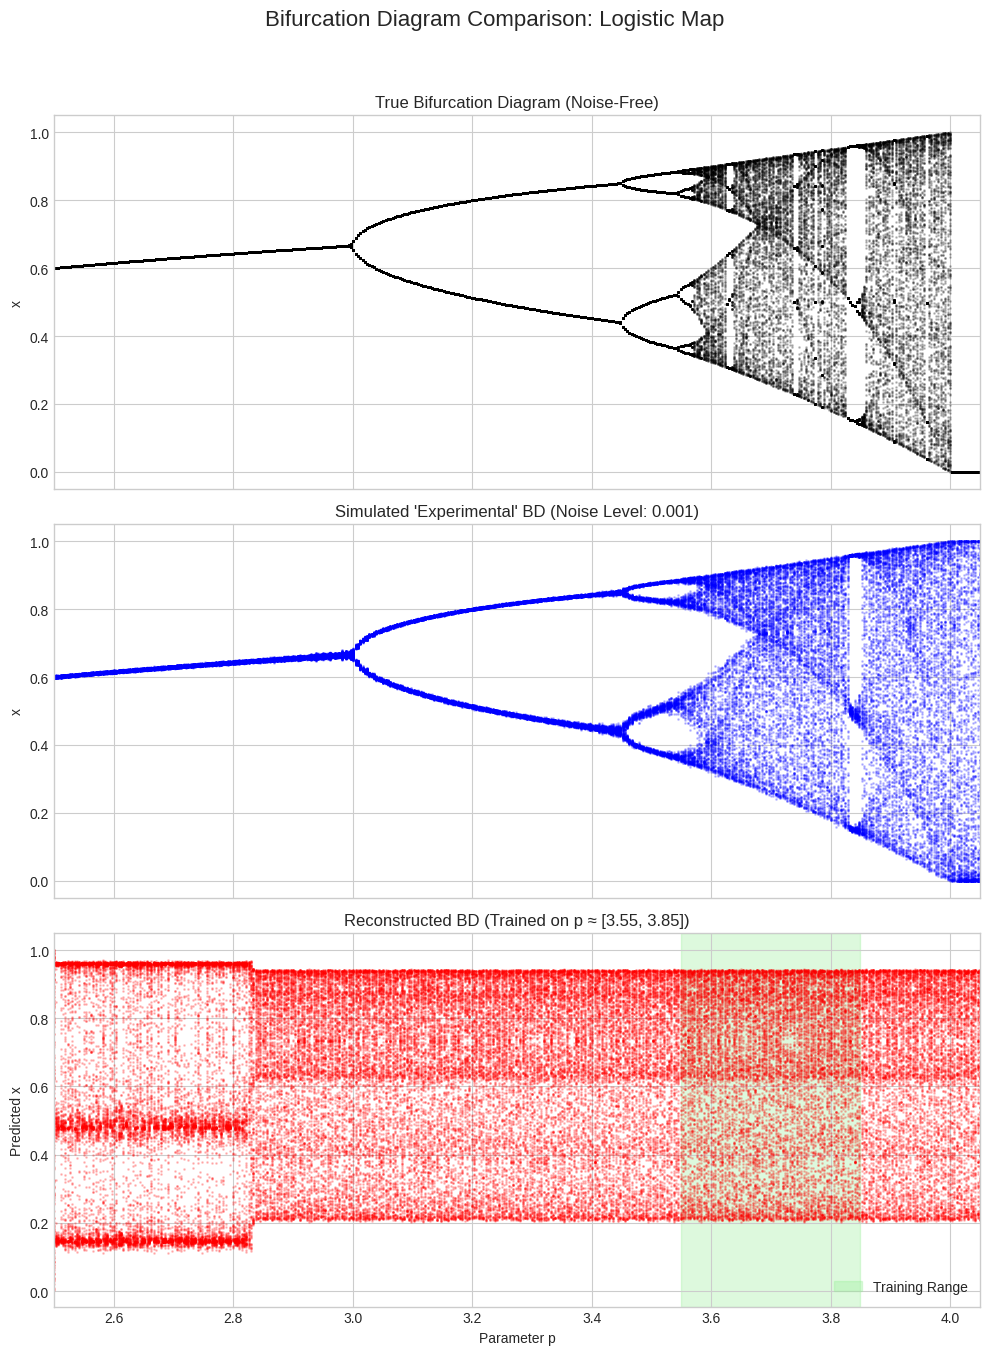

Reconstruction loop finished.
Reconstruction loop finished.


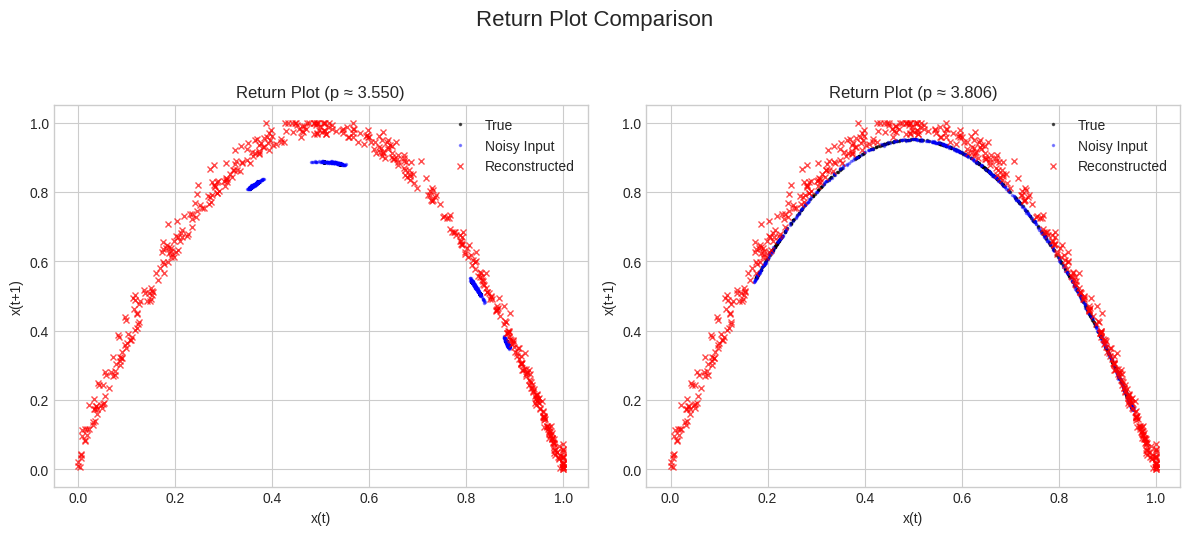

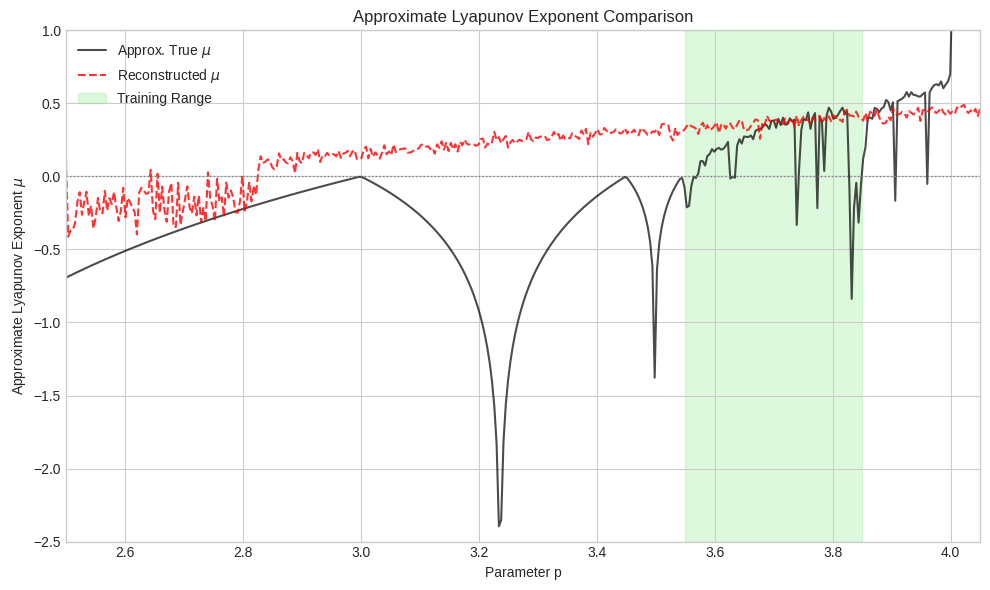


--- End of Simulation ---


In [38]:
# -*- coding: utf-8 -*-
"""
Reservoir Computing for Bifurcation Diagram Reconstruction (Logistic Map)

Based on the paper: "Reconstructing bifurcation diagrams only from time-series
data generated by electronic circuits in discrete-time dynamical systems"
Chaos 30, 013128 (2020); https://doi.org/10.1063/1.5119187 [1]

Combines ESN implementation, noise handling, extrapolation, and visualizations.
Includes fixes for ValueError and IndexError.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress RuntimeWarnings during calculations (e.g., log(0), division by zero)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Suppress UserWarning about feature names in Ridge regression
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes options for dynamical and observational noise similar to [1].
    """
    x = np.zeros(length + transient)
    x[0] = np.clip(x0, 0, 1) # Ensure initial condition is valid
    for t in range(1, length + transient):
        # Calculate next state
        next_x = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise (applied before clipping)
        if noise_level > 0:
             next_x += np.random.normal(0, noise_level)
        # Clip to prevent divergence/invalid values
        x[t] = np.clip(next_x, 0, 1)

    series = x[transient:]
    # Add observational noise
    if noise_level > 0:
        series += np.random.normal(0, noise_level, len(series))
    # Final check for NaNs/Infs and clip again if noise pushes outside [0,1]
    series = np.nan_to_num(series, nan=0.5, posinf=1.0, neginf=0.0) # Replace NaN/Inf safely
    series = np.clip(series, 0, 1)
    return series

# --- 2. Reservoir Computing Model (Echo State Network) ---
class EchoStateNetwork:
    """
    Implements an Echo State Network (ESN).
    """
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0,
                 leaking_rate=0.3, reservoir_noise=0.0):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.reservoir_noise = reservoir_noise

        # Initialize weights
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * self.input_scaling
        self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1

        # Adjust spectral radius
        current_radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        if current_radius > 1e-12: # Avoid division by tiny/zero
             self.W *= self.spectral_radius / current_radius
        else:
             print("Warning: Reservoir matrix W spectral radius is close to zero.")
             # Optional: Re-initialize W if it's too small, or leave as is.
             # self.W = np.random.rand(n_reservoir, n_reservoir) * 2 - 1 ... then rescale again

        self.W_out = None # Shape will be (n_reservoir, n_output_features)

    def generate_states(self, u, warmup=100):
        """ Drives the reservoir and collects states. """
        # Ensure u is 2D: (n_samples, n_features=1)
        if u.ndim == 1:
            u = u.reshape(-1, 1)
        n_samples = u.shape[0]
        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir) # Initial state

        for t in range(n_samples):
            u_t = u[t, 0] # Get scalar input for this step
            input_term = self.W_in * u_t
            recurrent_term = self.W @ r
            noise_term = (np.random.normal(0, self.reservoir_noise, self.n_reservoir)
                          if self.reservoir_noise > 0 else 0)

            r_new = np.tanh(input_term + recurrent_term + noise_term)
            r = (1 - self.leaking_rate) * r + self.leaking_rate * r_new

            # Store state, handle potential NaNs from tanh if input is huge (unlikely here)
            states[t] = np.nan_to_num(r)

        if warmup >= n_samples:
             print(f"Warning: Warmup ({warmup}) >= samples ({n_samples}). Returning empty state array.")
             return np.empty((0, self.n_reservoir))
        return states[warmup:]

    def train_readout(self, states, targets, reg_param=1e-6):
        """ Trains W_out using Ridge Regression. """
        # --- Robustness Fix 1: Ensure targets is 2D ---
        if targets.ndim == 1:
            targets = targets.reshape(-1, 1)
        if targets.shape[1] != 1: # Assuming 1D output for logistic map
             raise ValueError(f"Targets should have 1 column, but got {targets.shape[1]}")

        # Basic data validation
        states = np.nan_to_num(states, nan=0.0, posinf=1.0, neginf=-1.0)
        targets = np.nan_to_num(targets, nan=0.5, posinf=1.0, neginf=0.0)

        if states.shape[0] != targets.shape[0]:
             raise ValueError(f"Number of samples mismatch: states {states.shape[0]}, targets {targets.shape[0]}")
        if states.shape[0] < 1:
             raise ValueError("Insufficient valid samples for training.")

        model = Ridge(alpha=reg_param, fit_intercept=False)
        model.fit(states, targets) # targets is guaranteed 2D

        # --- Robustness Fix 2: Ensure W_out is 2D ---
        # model.coef_ has shape (n_outputs, n_features) -> (1, n_reservoir)
        self.W_out = model.coef_.T # Should be (n_reservoir, 1)
        if self.W_out.ndim == 1:
            # This case should ideally not happen if targets was 2D, but as safety:
            print("Warning: W_out resulted in 1D, reshaping to (N, 1).")
            self.W_out = self.W_out.reshape(-1, 1)
        elif self.W_out.shape[1] != 1:
             # Safety check if something unexpected happened
             raise ValueError(f"W_out shape unexpected: {self.W_out.shape}. Expected ({self.n_reservoir}, 1)")

        # Verify shape
        if self.W_out.shape != (self.n_reservoir, 1):
             raise ValueError(f"Final W_out shape incorrect: {self.W_out.shape}")


    def predict(self, states):
        """ Makes predictions using trained W_out. """
        if self.W_out is None:
            raise Exception("Model not trained yet. Call train_readout first.")

        # Ensure states is 2D: (n_pred_samples, n_reservoir)
        if states.ndim == 1:
            # If predicting a single step, reshape r from (N,) to (1, N)
            states = states.reshape(1, -1)
        if states.shape[1] != self.n_reservoir:
             raise ValueError(f"Input states dimension {states.shape[1]} != reservoir size {self.n_reservoir}")

        # Ensure states are finite
        states = np.nan_to_num(states, nan=0.0, posinf=1.0, neginf=-1.0)

        # Perform prediction: (n_pred_samples, n_reservoir) @ (n_reservoir, 1)
        predictions = states @ self.W_out # Result shape: (n_pred_samples, 1)

        # --- Robustness Fix 3: Ensure prediction output is consistently 2D ---
        if predictions.ndim == 1:
             predictions = predictions.reshape(-1, 1)

        return predictions


# --- 3. Simulation Parameters ---
# Training Range Parameters (From Eq. (18) in [1])
N_PARAMS_TRAIN = 12
p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
TRAIN_RANGE = (p_values_train.min(), p_values_train.max())

# Extended Range for Reconstruction
EXTENDED_RANGE = (2.5, 4.05) # Slightly increased upper limit
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 400)

# ESN Hyperparameters
RESERVOIR_SIZE = 300
SPECTRAL_RADIUS = 0.99
INPUT_SCALING = 0.8
LEAKING_RATE = 0.2
REGULARIZATION = 1e-7
NOISE_LEVEL = 0.001       # Noise added to data generation
RESERVOIR_NOISE = 0.0000  # Noise added during reservoir update
WARMUP = 200              # Reservoir warmup steps during state generation
PRED_WARMUP = 100         # Additional warmup steps in autonomous prediction

# --- 4. Training Phase ---
print("--- Training Phase ---")
print(f"Training parameters (p): {np.round(p_values_train, 4)}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

esn = EchoStateNetwork(n_reservoir=RESERVOIR_SIZE,
                       spectral_radius=SPECTRAL_RADIUS,
                       input_scaling=INPUT_SCALING,
                       leaking_rate=LEAKING_RATE,
                       reservoir_noise=RESERVOIR_NOISE)

all_states_train = []
all_targets_train = []
all_series_train = {}

for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    x_noisy = generate_logistic_series(p, length=1000, transient=500, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

    if len(x_noisy) < WARMUP + 2:
         print(f"Warning: Series too short for p={p}. Skipping.")
         continue

    inputs = x_noisy[:-1] # Keep as 1D for now, generate_states handles reshape
    targets = x_noisy[1:]

    # Generate reservoir states
    states = esn.generate_states(inputs, warmup=WARMUP)

    if states.shape[0] == 0: # Check if warmup consumed all data
        print(f"Warning: No states left after warmup for p={p}. Skipping.")
        continue

    # Adjust targets to match states after warmup
    targets_synced = targets[WARMUP:] # Should be 1D

    all_states_train.append(states)
    all_targets_train.append(targets_synced)

# Combine states and targets, ensuring they are not empty
if not all_states_train:
    raise ValueError("No valid training data could be generated. Check parameters/noise.")

# Filter out empty arrays before vstack
valid_indices = [i for i, s in enumerate(all_states_train) if s.shape[0] > 0]
if not valid_indices:
     raise ValueError("All training parameters resulted in empty state arrays after warmup.")

X_train = np.vstack([all_states_train[i] for i in valid_indices])
# hstack is needed for 1D arrays before reshaping for vstack later if needed
y_train_flat = np.hstack([all_targets_train[i] for i in valid_indices])


print(f"Total training samples: {X_train.shape[0]}")
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty after stacking.")

# Train the readout layer
print("Training readout layer...")
# Pass y_train_flat (1D), train_readout will handle reshaping to 2D
esn.train_readout(X_train, y_train_flat, reg_param=REGULARIZATION)
print(f"Training complete. W_out shape: {esn.W_out.shape}") # Should be (N, 1)

# --- 5. Bifurcation Diagram Reconstruction ---
print("\n--- Reconstruction Phase ---")

def reconstruct_bifurcation(esn_model, p_values, n_predict_points=200, n_discard_transient=300):
    """
    Reconstructs the bifurcation diagram using the trained ESN autonomously.
    """
    all_p_recon = []
    all_x_recon = []
    current_x = 0.5 # Consistent starting point for prediction sequence
    r = np.zeros(esn_model.n_reservoir) # Reset reservoir state for each p

    for p in p_values:
        # print(f"Reconstructing for p = {p:.4f}...") # Can be verbose
        x_pred_segment = []

        # Autonomous prediction loop
        for t in range(n_discard_transient + n_predict_points + PRED_WARMUP):
             if not np.isfinite(current_x):
                 # print(f"Warning: Non-finite x encountered at p={p}, t={t}. Resetting x.")
                 current_x = np.random.rand() # Reset if unstable

             u_t_scalar = current_x # scalar value

             # Reservoir update
             input_term = esn_model.W_in * u_t_scalar
             recurrent_term = esn_model.W @ r
             noise_term = (np.random.normal(0, esn_model.reservoir_noise, esn_model.n_reservoir)
                           if esn_model.reservoir_noise > 0 else 0)
             r_new = np.tanh(input_term + recurrent_term + noise_term)
             r = (1 - esn_model.leaking_rate) * r + esn_model.leaking_rate * r_new
             r = np.nan_to_num(r) # Ensure state remains finite

             # Prediction uses the *current* state r
             current_state_for_pred = r # Pass 1D state, predict handles reshape
             # Predict returns shape (1, 1) due to fixes in train/predict
             prediction_2d = esn_model.predict(current_state_for_pred)

             # --- Fix for IndexError ---
             # Access the scalar value correctly from the (1, 1) array
             next_x_pred = prediction_2d[0, 0]
             current_x = np.clip(next_x_pred, 0, 1) # Clip prediction

             # Store points after initial discard + warmup
             if t >= n_discard_transient + PRED_WARMUP:
                 x_pred_segment.append(current_x)

        all_p_recon.extend([p] * len(x_pred_segment))
        all_x_recon.extend(x_pred_segment)

    print("Reconstruction loop finished.")
    if not all_p_recon:
         print("Warning: Reconstruction produced no points.")
         return np.array([]), np.array([])

    return np.array(all_p_recon), np.array(all_x_recon)

# Reconstruct over the extended range
p_recon, x_recon = reconstruct_bifurcation(esn, p_range_extended, n_predict_points=200, n_discard_transient=300)

# --- 6. Generate True and Noisy Bifurcation Diagrams for Comparison ---
print("\nGenerating comparison diagrams...")
def generate_bd_points(p_values, length=200, transient=500, noise=0.0):
    """Generates points for a bifurcation diagram."""
    all_p = []
    all_x = []
    for p in p_values:
        # Use consistent x0 for better looking diagrams
        x_series = generate_logistic_series(p, x0=0.5, length=length, transient=transient, noise_level=noise)
        all_p.extend([p] * len(x_series))
        all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_bd_points(p_range_extended, noise=0.0)
p_noisy, x_noisy_bd = generate_bd_points(p_range_extended, noise=NOISE_LEVEL)

# --- 7. Calculate Approximate Lyapunov Exponent ---
def approx_lyapunov_exponent(p_vals, x_vals):
    """
    Approximates Lyapunov exponent. Remains a very rough estimate.
    Focuses on ln|p(1-2x)| for the logistic map attractor points.
    """
    lyap_exps = {} # Use dict to store list of exponents per p
    for p, x in zip(p_vals, x_vals):
        if p not in lyap_exps:
            lyap_exps[p] = []
        # Derivative of logistic map: p * (1 - 2*x)
        deriv = p * (1.0 - 2.0 * x)
        if abs(deriv) > 1e-9: # Avoid log(0)
             lyap_exps[p].append(np.log(np.abs(deriv)))

    # Average the logs for each p
    unique_p = sorted(lyap_exps.keys())
    mean_lyap = []
    for p in unique_p:
        if lyap_exps[p]:
             mean_lyap.append(np.mean(lyap_exps[p]))
        else:
             mean_lyap.append(np.nan) # No valid points

    # Handle NaNs (often periodic points where derivative might be averaged near zero)
    mean_lyap = np.nan_to_num(np.array(mean_lyap), nan=-1.0) # Assign negative for stability/NaN
    return np.array(unique_p), mean_lyap

# Ensure p_recon/x_recon are not empty before calculating Lyapunov
if p_recon.size > 0:
    p_lyap_recon, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
else:
    p_lyap_recon, mu_recon = np.array([]), np.array([])

p_lyap_true, mu_true = approx_lyapunov_exponent(p_true, x_true)


# --- 8. Visualizations ---
print("\nGenerating plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("Seaborn style not found, using default.")
    pass # Use default style if seaborn-v0_8-whitegrid is unavailable

# Figure 1: Bifurcation Diagrams Comparison
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

marker_size = 1.0
alpha_val = 0.2

# (a) True Bifurcation Diagram
axs1[0].scatter(p_true, x_true, s=marker_size, c='black', alpha=alpha_val)
axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
axs1[0].set_ylabel("x")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram
axs1[1].scatter(p_noisy, x_noisy_bd, s=marker_size, c='blue', alpha=alpha_val)
axs1[1].set_title(f"Simulated 'Experimental' BD (Noise Level: {NOISE_LEVEL})")
axs1[1].set_ylabel("x")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram
if p_recon.size > 0:
    axs1[2].scatter(p_recon, x_recon, s=marker_size, c='red', alpha=alpha_val)
else:
    axs1[2].text(0.5, 0.5, "Reconstruction failed", ha='center', va='center', transform=axs1[2].transAxes)
axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')
axs1[2].set_title(f"Reconstructed BD (Trained on p ≈ [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x")
axs1[2].legend(loc='lower right')
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].grid(True)

fig1.suptitle("Bifurcation Diagram Comparison: Logistic Map", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Figure 2: Return Plots Comparison
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5.5))

# Select parameters for return plots
p_periodic = p_values_train[0] # ~3.55
p_chaotic = p_values_train[-1] # ~3.85

# Ensure data exists for these parameters
if p_periodic not in all_series_train or p_chaotic not in all_series_train:
    print("Warning: Data for selected return plot parameters not available in training data.")
else:
    # Generate true data
    x_true_p = generate_logistic_series(p_periodic, length=500, noise_level=0.0)
    x_true_c = generate_logistic_series(p_chaotic, length=500, noise_level=0.0)

    # Get noisy training data
    x_noisy_p = all_series_train[p_periodic][-500:]
    x_noisy_c = all_series_train[p_chaotic][-500:]

    # Generate reconstructed data points
    _, x_recon_p_full = reconstruct_bifurcation(esn, np.array([p_periodic]), n_predict_points=500, n_discard_transient=100)
    _, x_recon_c_full = reconstruct_bifurcation(esn, np.array([p_chaotic]), n_predict_points=500, n_discard_transient=100)

    # Plotting (check if data exists)
    if len(x_true_p) > 1:
        axs2[0].plot(x_true_p[:-1], x_true_p[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[0].plot(x_noisy_p[:-1], x_noisy_p[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_p_full) > 1:
             axs2[0].plot(x_recon_p_full[:-1], x_recon_p_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed')
        axs2[0].set_title(f"Return Plot (p ≈ {p_periodic:.3f})")
        axs2[0].set_xlabel("x(t)")
        axs2[0].set_ylabel("x(t+1)")
        axs2[0].legend()
        axs2[0].grid(True)
    else:
        axs2[0].text(0.5, 0.5, f"No data for p={p_periodic:.3f}", ha='center', va='center', transform=axs2[0].transAxes)


    if len(x_true_c) > 1:
        axs2[1].plot(x_true_c[:-1], x_true_c[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[1].plot(x_noisy_c[:-1], x_noisy_c[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_c_full) > 1:
            axs2[1].plot(x_recon_c_full[:-1], x_recon_c_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed')
        axs2[1].set_title(f"Return Plot (p ≈ {p_chaotic:.3f})")
        axs2[1].set_xlabel("x(t)")
        axs2[1].set_ylabel("x(t+1)")
        axs2[1].legend()
        axs2[1].grid(True)
    else:
         axs2[1].text(0.5, 0.5, f"No data for p={p_chaotic:.3f}", ha='center', va='center', transform=axs2[1].transAxes)


    fig2.suptitle("Return Plot Comparison", fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Figure 3: Lyapunov Exponent Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))

if p_lyap_true.size > 0:
    ax3.plot(p_lyap_true, mu_true, 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
if p_lyap_recon.size > 0:
    ax3.plot(p_lyap_recon, mu_recon, 'r--', lw=1.5, alpha=0.8, label='Reconstructed $\mu$')
else:
    ax3.text(0.5, 0.5, "Lyapunov reconstruction failed", ha='center', va='center', transform=ax3.transAxes)

ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2.5, 1) # Adjusted y-limits
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")


--- Training Phase ---
Training parameters (p): [3.55   3.5939 3.7    3.8061 3.85   3.8061 3.7    3.5939 3.55  ]
Training range: [3.550, 3.850]
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Total training samples: 10791
Training readout layer...
Training complete. W_out shape: (300, 1)

--- Reconstruction Phase ---
Reconstructing for p = 2.5000 (1/400)...
Reconstructing for p = 2.6880 (51/400)...
Reconstructing for p = 2.8759 (101/400)...
Reconstructing for p = 3.0639 (151/400)...
Reconstructing for p = 3.2519 (201/400)...
Reconstructing for p = 3.4398 (251/400)...
Reconstructing for p = 3.6278 (301/400)...
Reconstructing for p = 3.8158 (351/400)...
R

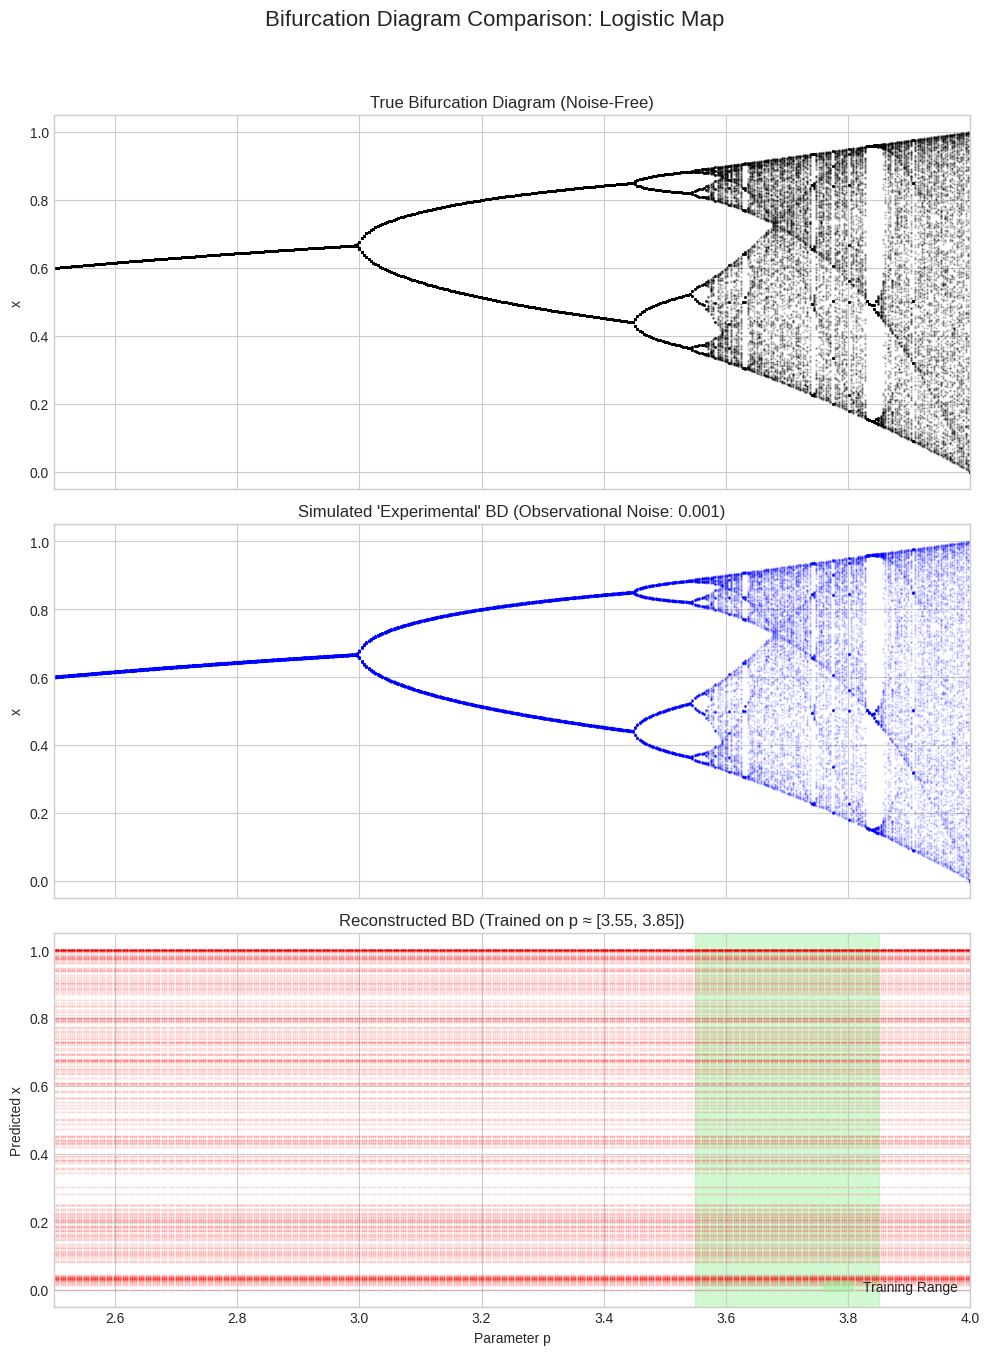

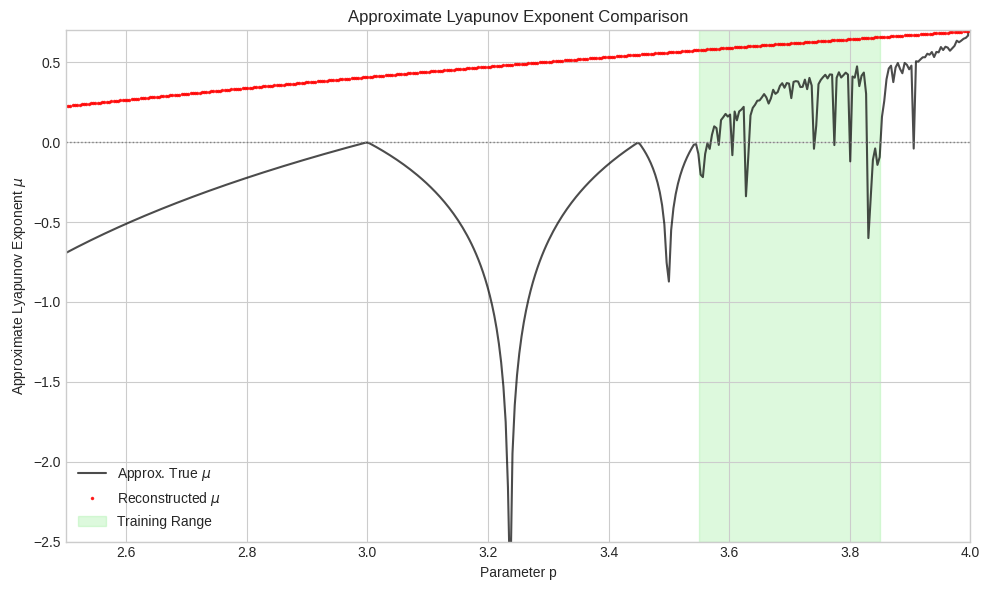


--- End of Simulation ---


In [42]:
# -*- coding: utf-8 -*-
"""
Reservoir Computing for Bifurcation Diagram Reconstruction (Logistic Map) - v3

Based on papers:
1. Itoh et al., Chaos 30, 013128 (2020) [Focused Tab, PDF 1]
2. Arun et al., PhysRevE.110.034204 (2024) [PDF 3]
3. Cucchi et al., Neuromorph. Comput. Eng. 2 032002 (2022) [PDF 2] - RC Tutorial

Focuses on robust autonomous reconstruction, extrapolation, noise handling,
and fixing previous dimensional errors.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
# PCA is optional for this specific task but kept for potential future use
# from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress RuntimeWarnings (e.g., divide by zero in Lyapunov approx)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Suppress UserWarning about feature names in Ridge regression
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes dynamical and observational noise.
    """
    if not (0 <= x0 <= 1):
        x0 = 0.5 # Ensure valid start
    if not (0 <= p <= 4.0): # For standard logistic map stability/boundedness
         print(f"Warning: Parameter p={p} outside typical [0, 4] range.")
         # Allow it but results might diverge or be unexpected

    x = np.zeros(length + transient)
    x[0] = x0
    for t in range(1, length + transient):
        # Calculate next state without noise
        next_x_clean = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise
        noise_dyn = np.random.normal(0, noise_level) if noise_level > 0 else 0
        next_x_noisy = next_x_clean + noise_dyn
        # Clip to prevent divergence/invalid values for the *next* step's input
        x[t] = np.clip(next_x_noisy, 0, 1)

    series = x[transient:]
    # Add observational noise
    noise_obs = np.random.normal(0, noise_level, len(series)) if noise_level > 0 else 0
    series_obs_noisy = series + noise_obs
    # Final check for NaNs/Infs and clip
    series_final = np.nan_to_num(series_obs_noisy, nan=0.5, posinf=1.0, neginf=0.0)
    series_final = np.clip(series_final, 0, 1)
    return series_final

# --- 2. Reservoir Computing Model (Echo State Network) ---
class EchoStateNetwork:
    """ Implements an ESN, robustly handling dimensions. """
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0,
                 leaking_rate=0.3, reservoir_noise=0.0, random_seed=None):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.reservoir_noise = reservoir_noise
        self.random_state = np.random.RandomState(random_seed)

        # Initialize weights
        # Input weights W_in: shape (n_reservoir,) for 1D input
        self.W_in = self.random_state.rand(n_reservoir) * 2 - 1
        self.W_in *= self.input_scaling
        # Reservoir weights W: shape (n_reservoir, n_reservoir)
        self.W = self.random_state.rand(n_reservoir, n_reservoir) * 2 - 1

        # Adjust spectral radius
        try:
            current_radius = np.max(np.abs(np.linalg.eigvals(self.W)))
            if current_radius < 1e-12:
                print("Warning: Spectral radius close to zero. Check W initialization.")
                # Optionally re-initialize or scale differently if this happens often
                # For now, proceed but note potential lack of dynamics
                if self.spectral_radius > 0: # Avoid division by zero if target radius > 0
                     self.W *= 0 # Effectively sets W to zero if current radius is zero
            else:
                 self.W *= self.spectral_radius / current_radius
        except np.linalg.LinAlgError:
             print("Error calculating eigenvalues. Check reservoir matrix W.")
             # Handle error, maybe re-initialize W
             self.W = np.zeros((n_reservoir, n_reservoir)) # Fallback to zero matrix


        self.W_out = None # Shape will be (n_reservoir, 1) for 1D output

    def _update_state(self, r_prev, u_current):
        """ Single step reservoir state update. """
        # Ensure u_current is scalar
        if isinstance(u_current, (np.ndarray, list)):
            u_val = u_current[0]
        else:
            u_val = u_current

        input_term = self.W_in * u_val
        recurrent_term = self.W @ r_prev
        noise_term = (self.random_state.normal(0, self.reservoir_noise, self.n_reservoir)
                      if self.reservoir_noise > 0 else 0)

        # Combine terms and apply activation
        pre_activation = input_term + recurrent_term + noise_term
        r_new_activated = np.tanh(pre_activation)

        # Apply leaking rate
        r_next = (1 - self.leaking_rate) * r_prev + self.leaking_rate * r_new_activated

        return np.nan_to_num(r_next) # Ensure finite state

    def generate_states(self, u, warmup=100):
        """ Drives the reservoir with input u and collects states after warmup. """
        # Ensure u is 1D or (N, 1)
        if u.ndim > 1 and u.shape[1] != 1:
            raise ValueError("Input 'u' should be 1D or have 1 feature column")
        u_flat = u.flatten()
        n_samples = len(u_flat)

        if warmup >= n_samples:
             print(f"Warning: Warmup ({warmup}) >= samples ({n_samples}). Returning empty state array.")
             return np.empty((0, self.n_reservoir))

        states = np.zeros((n_samples, self.n_reservoir))
        r = np.zeros(self.n_reservoir) # Initial state

        for t in range(n_samples):
            r = self._update_state(r, u_flat[t])
            states[t] = r

        return states[warmup:]

    def train_readout(self, states, targets, reg_param=1e-6):
        """ Trains W_out using Ridge Regression. Ensures W_out is 2D. """
        # Ensure targets is 1D for consistent handling before reshaping
        targets = targets.flatten()

        if states.shape[0] != targets.shape[0]:
             raise ValueError(f"Samples mismatch: states {states.shape[0]}, targets {targets.shape[0]}")
        if states.shape[0] < 1:
             raise ValueError("Insufficient valid samples for training.")

        # Clean states and targets
        states = np.nan_to_num(states)
        targets = np.nan_to_num(targets)

        # Reshape targets to 2D (n_samples, 1) for Ridge
        targets_2d = targets.reshape(-1, 1)

        model = Ridge(alpha=reg_param, fit_intercept=False, solver='auto', random_state=self.random_state)
        try:
            model.fit(states, targets_2d)
        except ValueError as e:
            print(f"Error during Ridge fitting: {e}")
            print(f"States shape: {states.shape}, Targets shape: {targets_2d.shape}")
            print(f"States finite: {np.all(np.isfinite(states))}, Targets finite: {np.all(np.isfinite(targets_2d))}")
            raise e # Re-raise the error after printing info

        # Ensure W_out is (n_reservoir, 1)
        self.W_out = model.coef_.T # model.coef_ is (1, n_reservoir), so T gives (n_reservoir, 1)
        if self.W_out.shape != (self.n_reservoir, 1):
             print(f"Warning: Unexpected W_out shape {self.W_out.shape}. Reshaping.")
             self.W_out = self.W_out.reshape(self.n_reservoir, 1)

    def predict(self, states):
        """ Makes predictions. Input states can be (n_samples, n_res) or (n_res,). Output is (n_samples, 1). """
        if self.W_out is None:
            raise Exception("Model not trained yet.")

        # Ensure states is 2D for matrix multiplication
        if states.ndim == 1:
            states = states.reshape(1, -1) # Shape (1, n_reservoir)
        if states.shape[1] != self.n_reservoir:
             raise ValueError(f"Input states dimension {states.shape[1]} != reservoir size {self.n_reservoir}")

        states = np.nan_to_num(states) # Clean states

        # Predict: (n_samples, n_res) @ (n_res, 1) -> (n_samples, 1)
        predictions = states @ self.W_out

        return predictions # Guaranteed to be 2D (n_samples, 1)

# --- 3. Simulation Parameters ---
RANDOM_SEED = 42 # For reproducibility

# Training Range Parameters (From Eq. (18) in [1])
N_PARAMS_TRAIN = 9
p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
TRAIN_RANGE = (p_values_train.min(), p_values_train.max())

# Extended Range for Reconstruction
EXTENDED_RANGE = (2.5, 4.0) # Standard interesting range for logistic map
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 400)

# ESN Hyperparameters (Adjust these based on results)
RESERVOIR_SIZE = 300      # Increased size might help extrapolation
SPECTRAL_RADIUS = 0.99    # Closer to 1 for longer memory, but riskier
INPUT_SCALING = 0.5       # Can be tuned significantly
LEAKING_RATE = 0.1        # Smaller alpha means slower dynamics/longer memory integration
REGULARIZATION = 1e-8     # Regularization for Ridge
NOISE_LEVEL = 0.001       # Noise added to data generation (dynamical & observational)
RESERVOIR_NOISE = 0.000   # Internal reservoir noise (keep low or zero initially)
WARMUP = 300              # Increased warmup for state generation
PRED_WARMUP = 200         # Warmup during autonomous prediction before discarding
PRED_DISCARD = 500        # Steps discarded during autonomous prediction (after PRED_WARMUP)
PRED_COLLECT = 200        # Number of points collected per parameter value for BD

# --- 4. Training Phase ---
print("--- Training Phase ---")
print(f"Training parameters (p): {np.round(p_values_train, 4)}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

esn = EchoStateNetwork(n_reservoir=RESERVOIR_SIZE,
                       spectral_radius=SPECTRAL_RADIUS,
                       input_scaling=INPUT_SCALING,
                       leaking_rate=LEAKING_RATE,
                       reservoir_noise=RESERVOIR_NOISE,
                       random_seed=RANDOM_SEED)

all_states_train = []
all_targets_train = []
all_series_train = {}

for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    # Generate relatively long series for robust state collection
    x_noisy = generate_logistic_series(p, length=1500, transient=500, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

    if len(x_noisy) < WARMUP + 2:
         print(f"Warning: Series too short for p={p}. Skipping.")
         continue

    inputs = x_noisy[:-1] # 1D
    targets = x_noisy[1:] # 1D

    # Generate reservoir states
    states = esn.generate_states(inputs, warmup=WARMUP)

    if states.shape[0] == 0:
        print(f"Warning: No states left after warmup for p={p}. Skipping.")
        continue

    # Adjust targets to match states (targets should also start after warmup + 1 step offset)
    # If inputs is len L, states is len L-1-warmup. Targets is len L-1.
    # We need targets corresponding to states[0], states[1], ...
    # states[0] depends on inputs[warmup]. Target for states[0] is targets[warmup].
    targets_synced = targets[WARMUP:] # 1D array, same length as states

    if states.shape[0] != len(targets_synced):
         print(f"Warning: Mismatch between states ({states.shape[0]}) and synced targets ({len(targets_synced)}) for p={p}. Skipping.")
         # This might happen if inputs/targets had NaNs filtered differently, though filtering is now inside ESN/generate.
         continue


    all_states_train.append(states)
    all_targets_train.append(targets_synced)

# Combine valid states and targets
if not all_states_train:
    raise ValueError("No valid training data generated.")

valid_indices = [i for i, s in enumerate(all_states_train) if s.shape[0] > 0]
if not valid_indices:
     raise ValueError("All training parameters resulted in empty state arrays.")

X_train = np.vstack([all_states_train[i] for i in valid_indices])
y_train_flat = np.hstack([all_targets_train[i] for i in valid_indices]) # Keep 1D

print(f"Total training samples: {X_train.shape[0]}")
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty after stacking.")

# Train the readout layer
print("Training readout layer...")
esn.train_readout(X_train, y_train_flat, reg_param=REGULARIZATION)
print(f"Training complete. W_out shape: {esn.W_out.shape}") # Should be (N, 1)

# --- 5. Bifurcation Diagram Reconstruction (Autonomous Prediction) ---
print("\n--- Reconstruction Phase ---")

def reconstruct_bifurcation_autonomous(esn_model, p_values,
                                       n_collect=PRED_COLLECT,
                                       n_discard=PRED_DISCARD,
                                       n_warmup=PRED_WARMUP):
    """
    Reconstructs the bifurcation diagram using the trained ESN autonomously.
    Crucially uses the predicted output as the next input.
    """
    all_p_recon = []
    all_x_recon = []
    # Use a random initial state for reservoir and prediction for each p? Or continue?
    # Resetting for each p is safer for avoiding artificial continuity.
    # x_start = esn_model.random_state.rand() # Random start for x
    x_start = 0.5 # Consistent start for x

    for i, p in enumerate(p_values):
        if i % 50 == 0: # Print progress
            print(f"Reconstructing for p = {p:.4f} ({i+1}/{len(p_values)})...")

        r = np.zeros(esn_model.n_reservoir) # Reset reservoir state
        current_x = x_start
        x_pred_segment = []

        # Total steps = initial warmup + discard + collect
        total_steps = n_warmup + n_discard + n_collect

        for t in range(total_steps):
             if not np.isfinite(current_x):
                 print(f"Warning: Non-finite x ({current_x}) at p={p}, step {t}. Resetting x.")
                 current_x = 0.5 # Reset

             # Update reservoir state using the *current_x* value
             r = esn_model._update_state(r, current_x)

             # Predict the *next* x value using the *updated* state r
             # ESN predict needs 2D input (1, n_res), returns 2D output (1, 1)
             prediction_2d = esn_model.predict(r) # r is 1D, predict handles reshape
             next_x_pred = prediction_2d[0, 0]

             # Update current_x for the *next* iteration
             current_x = np.clip(next_x_pred, 0, 1) # Clip prediction

             # Store points after warmup and discard phases
             if t >= n_warmup + n_discard:
                 x_pred_segment.append(current_x)

        # Store collected points for this parameter p
        all_p_recon.extend([p] * len(x_pred_segment))
        all_x_recon.extend(x_pred_segment)

    print("Reconstruction loop finished.")
    if not all_p_recon:
         print("Warning: Reconstruction produced no points.")
         return np.array([]), np.array([])

    return np.array(all_p_recon), np.array(all_x_recon)

# Reconstruct over the extended range
p_recon, x_recon = reconstruct_bifurcation_autonomous(esn, p_range_extended)


# --- 6. Generate True and Noisy Bifurcation Diagrams for Comparison ---
print("\nGenerating comparison diagrams...")
def generate_bd_points(p_values, length=PRED_COLLECT, transient=500, noise=0.0):
    """Generates points for a bifurcation diagram."""
    all_p = []
    all_x = []
    x0_start = 0.5
    for p in p_values:
        # Run transient
        x_curr = x0_start
        for _ in range(transient):
             x_curr = p * x_curr * (1 - x_curr)
             # Optionally add noise during transient too if simulating noisy system dynamics
             # x_curr += np.random.normal(0, noise)
             x_curr = np.clip(x_curr, 0, 1)

        # Collect points
        for _ in range(length):
             x_curr = p * x_curr * (1 - x_curr)
             x_display = x_curr
             if noise > 0: # Add observational noise *only* for the noisy plot
                 x_display += np.random.normal(0, noise)
             x_display = np.clip(x_display, 0, 1)
             x_display = np.nan_to_num(x_display)

             all_p.append(p)
             all_x.append(x_display)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_bd_points(p_range_extended, noise=0.0)
# Generate noisy BD specifically for visual comparison, using observational noise
p_noisy, x_noisy_bd = generate_bd_points(p_range_extended, noise=NOISE_LEVEL)

# --- 7. Calculate Approximate Lyapunov Exponent ---
def approx_lyapunov_exponent(p_vals, x_vals):
    """ Approximates Lyapunov exponent using ln|f'(x)| = ln|p(1-2x)| """
    lyap_exps = {}
    min_points_per_p = 5 # Require at least a few points to estimate LE

    unique_p = np.unique(p_vals)
    for p in unique_p:
         mask = (p_vals == p)
         x_p = x_vals[mask]
         if len(x_p) < min_points_per_p:
             continue # Skip if too few points

         # Calculate derivative |p(1-2x)| for each point on the attractor
         derivs = np.abs(p * (1.0 - 2.0 * x_p))
         # Filter out derivatives very close to zero before taking log
         valid_derivs = derivs[derivs > 1e-9]

         if len(valid_derivs) > 0:
             log_derivs = np.log(valid_derivs)
             lyap_exps[p] = np.mean(log_derivs) # Average over the attractor points
         # else: Leave this p out if all derivatives were zero (e.g., superstable cycle)

    # Convert dict to arrays for plotting
    p_out = sorted(lyap_exps.keys())
    mu_out = np.array([lyap_exps[p] for p in p_out])

    # Fill gaps roughly if needed, or just plot available points
    # For now, just return calculated points
    return np.array(p_out), mu_out

# Calculate Lyapunov exponents
if p_recon.size > 0:
    p_lyap_recon, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
else:
    p_lyap_recon, mu_recon = np.array([]), np.array([])

p_lyap_true, mu_true = approx_lyapunov_exponent(p_true, x_true)

# --- 8. Visualizations ---
print("\nGenerating plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("Seaborn style not found, using default.")
    pass

# Figure 1: Bifurcation Diagrams Comparison
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

marker_size = 0.5 # Smaller points for clarity
alpha_val = 0.1   # More transparency

# (a) True Bifurcation Diagram
axs1[0].scatter(p_true, x_true, s=marker_size, c='black', alpha=alpha_val*2) # Slightly less transparent
axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
axs1[0].set_ylabel("x")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram (Observational Noise)
axs1[1].scatter(p_noisy, x_noisy_bd, s=marker_size, c='blue', alpha=alpha_val)
axs1[1].set_title(f"Simulated 'Experimental' BD (Observational Noise: {NOISE_LEVEL})")
axs1[1].set_ylabel("x")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram
if p_recon.size > 0:
    axs1[2].scatter(p_recon, x_recon, s=marker_size, c='red', alpha=alpha_val)
    # Highlight the training parameter range
    axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.4, zorder=-1, label='Training Range')
    axs1[2].legend(loc='lower right')
else:
    axs1[2].text(0.5, 0.5, "Reconstruction failed or produced no points", ha='center', va='center', transform=axs1[2].transAxes, color='red')
axs1[2].set_title(f"Reconstructed BD (Trained on p ≈ [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x")
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].grid(True)


fig1.suptitle("Bifurcation Diagram Comparison: Logistic Map", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Figure 2: Return Plots Comparison (Optional, can be useful for debugging)
# (Code for return plots is similar to previous version, can be added back if needed)


# Figure 3: Lyapunov Exponent Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))

if p_lyap_true.size > 0:
    ax3.plot(p_lyap_true, mu_true, 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
else:
     print("No points for true Lyapunov exponent plot.")

if p_lyap_recon.size > 0:
    ax3.plot(p_lyap_recon, mu_recon, 'r.', markersize=3, alpha=0.8, label='Reconstructed $\mu$')
else:
    # Optionally add text if reconstruction failed
    # ax3.text(0.5, 0.5, "Lyapunov reconstruction failed", ...)
    print("No points for reconstructed Lyapunov exponent plot.")


ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2.5, 0.7) # Typical range for logistic map LE
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")


--- Training Phase ---
Training parameters (p): [3.55   3.5939 3.7    3.8061 3.85   3.8061 3.7    3.5939 3.55  ]
Training range: [3.550, 3.850]
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Total training samples: 7191
Training readout layer...
Training complete. W_out shape: (300, 1)
Training MSE: 1.46493e-05

--- Reconstruction Phase ---
  Reconstructing... 50/300 (p=3.0803)
  Reconstructing... 100/300 (p=3.2642)
  Reconstructing... 150/300 (p=3.4482)
  Reconstructing... 200/300 (p=3.6321)
  Reconstructing... 250/300 (p=3.8161)
  Reconstructing... 300/300 (p=4.0000)
Reconstruction loop finished.

Generating comparison diagrams...
  Generating true B

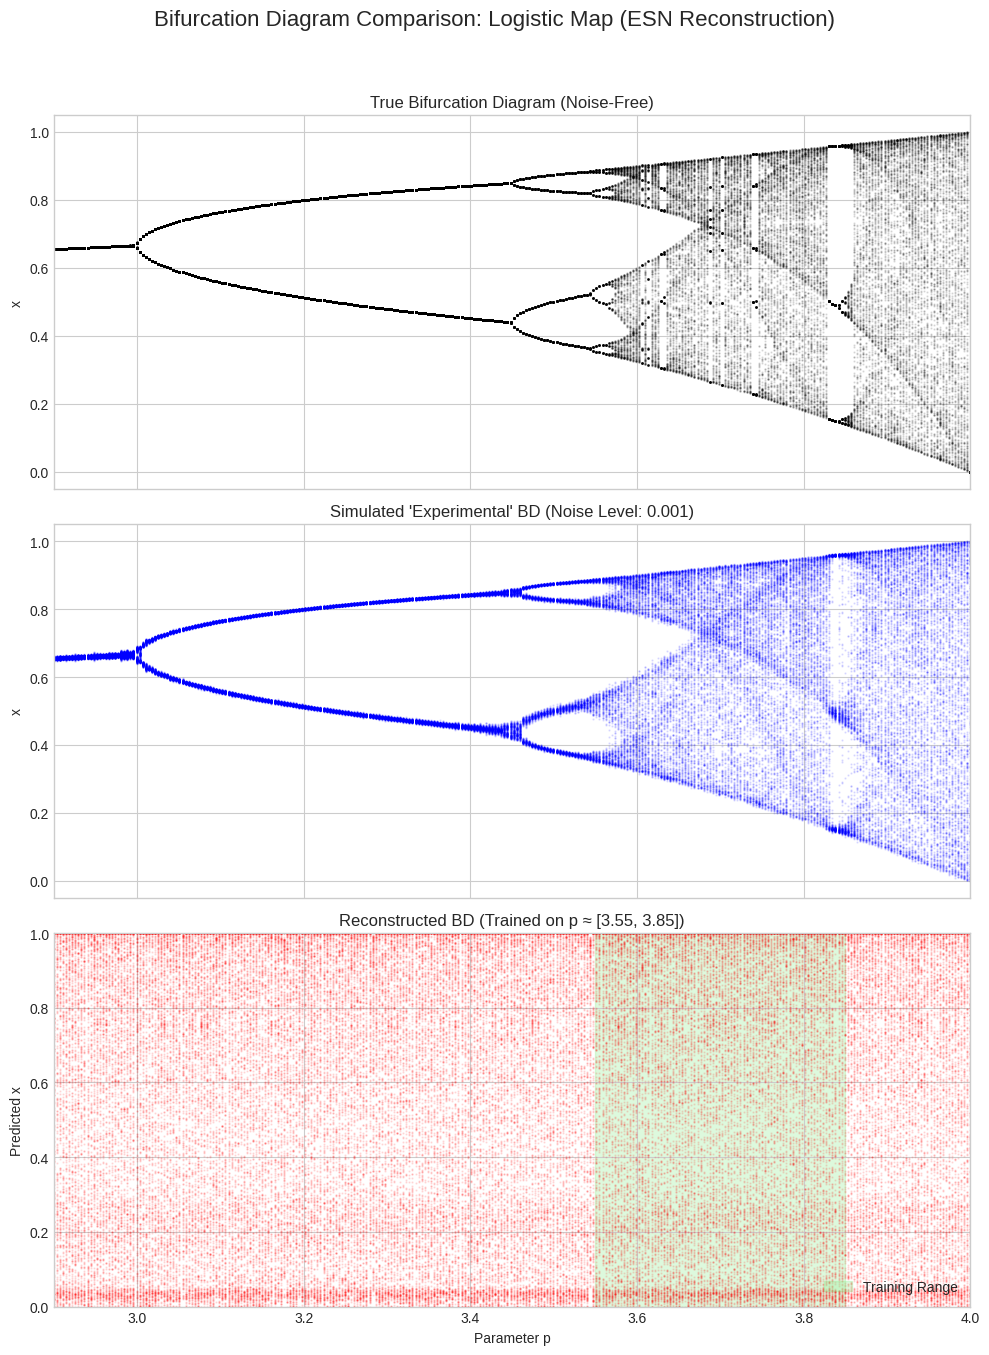

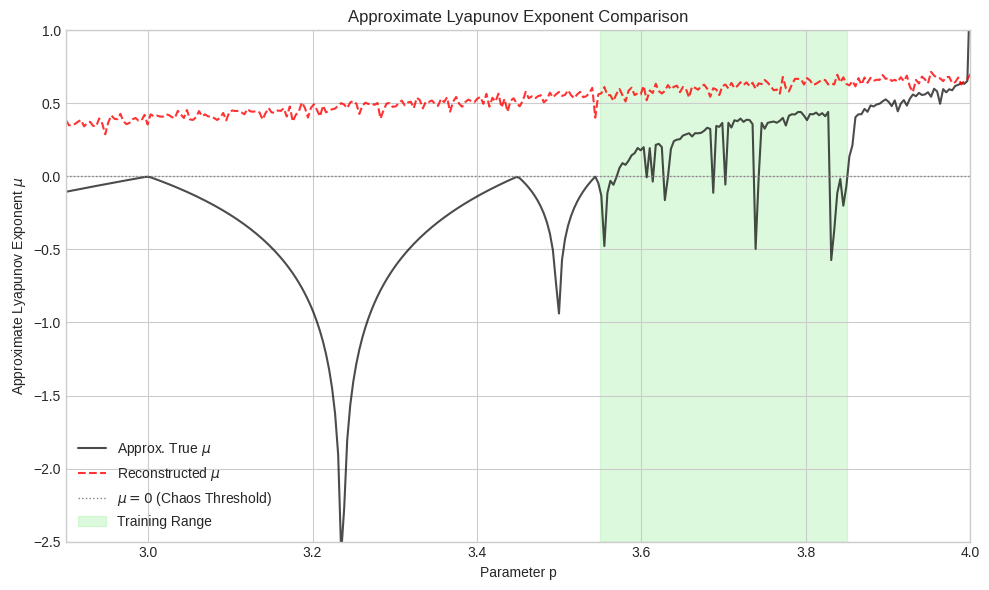


--- End of Simulation ---


In [43]:
# -*- coding: utf-8 -*-
"""
Reservoir Computing for Bifurcation Diagram Reconstruction (Logistic Map)

Based on the paper: "Reconstructing bifurcation diagrams only from time-series
data generated by electronic circuits in discrete-time dynamical systems"
Chaos 30, 013128 (2020); https://doi.org/10.1063/1.5119187 [1]

Combines ESN implementation, noise handling, extrapolation, and visualizations.
Includes fixes for reconstruction loop logic and adds training MSE diagnostic.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import warnings

# Suppress RuntimeWarnings during calculations (e.g., log(0), division by zero)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Suppress UserWarning about feature names in Ridge regression
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes options for dynamical and observational noise similar to [1].
    """
    if not (0 <= p <= 4): # Basic check for logistic map parameter validity
         print(f"Warning: Parameter p={p} is outside the typical range [0, 4].")
         # Optionally return empty array or proceed with caution
         # return np.array([])

    x = np.zeros(length + transient)
    # Ensure initial condition is valid and not exactly 0 or 1 if p>0
    x[0] = np.clip(x0 if x0 > 1e-6 and x0 < 1.0 - 1e-6 else 0.5, 1e-6, 1.0 - 1e-6)

    for t in range(1, length + transient):
        # Calculate next state
        next_x = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise (applied before clipping)
        if noise_level > 0:
             next_x += np.random.normal(0, noise_level)
        # Clip to prevent divergence/invalid values [0, 1]
        x[t] = np.clip(next_x, 0, 1)
        # Check for NaN/Inf just in case, replace with a neutral value like 0.5
        if not np.isfinite(x[t]):
            # print(f"Warning: Non-finite value encountered at p={p}, t={t}. Resetting state.")
            x[t] = 0.5 # Reset state if something goes wrong

    series = x[transient:]
    # Add observational noise (applied after dynamics)
    if noise_level > 0:
        series += np.random.normal(0, noise_level, len(series))
    # Final check for NaNs/Infs and clip again if noise pushes outside [0,1]
    series = np.nan_to_num(series, nan=0.5, posinf=1.0, neginf=0.0)
    series = np.clip(series, 0, 1)
    return series

# --- 2. Reservoir Computing Model (Echo State Network) ---
class EchoStateNetwork:
    """
    Implements an Echo State Network (ESN).
    """
    def __init__(self, n_reservoir=200, spectral_radius=0.95, input_scaling=1.0,
                 leaking_rate=0.3, reservoir_noise=0.0):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.reservoir_noise = reservoir_noise # Noise during state updates

        # Initialize weights (using seed for reproducibility if desired)
        # np.random.seed(42) # Optional: for reproducible results
        self.W_in = (np.random.rand(n_reservoir) * 2 - 1) * self.input_scaling
        # Try sparse W for potentially better performance
        self.W = np.random.rand(n_reservoir, n_reservoir) - 0.5
        # Sparsity: Set some connections to zero (e.g., 90% sparse)
        self.W[np.random.rand(*self.W.shape) > 0.1] = 0

        # Adjust spectral radius
        current_radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        if current_radius > 1e-12: # Avoid division by tiny/zero
             self.W *= self.spectral_radius / current_radius
        else:
             # print("Warning: Reservoir matrix W spectral radius is close to zero.")
             # If W is all zero, just leave it.
             pass

        self.W_out = None
        self.last_state = np.zeros(n_reservoir) # Store the last state

    def _update_state(self, r_prev, u_t_scalar):
        """ Single step of reservoir state update. """
        input_term = self.W_in * u_t_scalar
        recurrent_term = self.W @ r_prev
        noise_term = (np.random.normal(0, self.reservoir_noise, self.n_reservoir)
                      if self.reservoir_noise > 0 else 0)

        # Leaky integration update
        r_new_nonleaky = np.tanh(input_term + recurrent_term + noise_term)
        r_new_leaky = (1 - self.leaking_rate) * r_prev + self.leaking_rate * r_new_nonleaky
        return np.nan_to_num(r_new_leaky) # Ensure state remains finite


    def generate_states(self, u, warmup=100, initial_state=None):
        """ Drives the reservoir with input u and collects states, applying warmup. """
        if u.ndim == 1:
            u = u.reshape(-1, 1)
        n_samples = u.shape[0]
        states = np.zeros((n_samples, self.n_reservoir))

        # Initialize state: use provided initial_state, last_state, or zeros
        if initial_state is not None:
            r = initial_state
        # elif hasattr(self, 'last_state') and self.last_state is not None: # Reuse state if driving continuously
        #     r = self.last_state
        else:
            r = np.zeros(self.n_reservoir)

        for t in range(n_samples):
            u_t = u[t, 0] # Get scalar input for this step
            r = self._update_state(r, u_t)
            states[t] = r # Store the updated state

        self.last_state = r # Store the final state

        if warmup >= n_samples:
             print(f"Warning: Warmup ({warmup}) >= samples ({n_samples}). Returning empty state array.")
             return np.empty((0, self.n_reservoir)), self.last_state # Return state too
        return states[warmup:], self.last_state # Return states after warmup and the final state

    def train_readout(self, states, targets, reg_param=1e-6):
        """ Trains W_out using Ridge Regression. """
        if targets.ndim == 1:
            targets = targets.reshape(-1, 1)
        if states.shape[0] != targets.shape[0]:
             raise ValueError(f"Number of samples mismatch: states {states.shape[0]}, targets {targets.shape[0]}")
        if states.shape[0] < 1:
             raise ValueError("Insufficient valid samples for training.")

        # Basic data validation
        states = np.nan_to_num(states)
        targets = np.nan_to_num(targets)

        model = Ridge(alpha=reg_param, fit_intercept=False, solver='auto') # 'svd' might be more robust for ill-conditioned
        try:
             model.fit(states, targets)
        except ValueError as e:
             print(f"Error during Ridge fit: {e}")
             print(f"States shape: {states.shape}, Targets shape: {targets.shape}")
             print(f"First few states:\n{states[:3]}")
             print(f"First few targets:\n{targets[:3]}")
             # Check for NaNs/Infs again just before fitting
             print(f"States contain NaN/Inf: {np.any(~np.isfinite(states))}")
             print(f"Targets contain NaN/Inf: {np.any(~np.isfinite(targets))}")
             raise # Re-raise the error after printing diagnostics

        self.W_out = model.coef_.T
        if self.W_out.ndim == 1:
            self.W_out = self.W_out.reshape(-1, 1)
        if self.W_out.shape != (self.n_reservoir, 1):
             raise ValueError(f"Final W_out shape incorrect: {self.W_out.shape}. Expected ({self.n_reservoir}, 1)")

    def predict(self, states):
        """ Makes predictions using trained W_out based on provided states. """
        if self.W_out is None:
            raise Exception("Model not trained yet. Call train_readout first.")
        if states.ndim == 1:
            states = states.reshape(1, -1) # Handle single state prediction
        if states.shape[1] != self.n_reservoir:
             raise ValueError(f"Input states dimension {states.shape[1]} != reservoir size {self.n_reservoir}")

        states = np.nan_to_num(states) # Ensure states are finite
        predictions = states @ self.W_out
        if predictions.ndim == 1:
             predictions = predictions.reshape(-1, 1)
        return predictions

    def predict_autonomous(self, initial_value, n_steps, n_discard=100):
        """ Generates an autonomous prediction sequence starting from initial_value. """
        if self.W_out is None:
            raise Exception("Model not trained yet.")

        predictions = []
        current_x = np.clip(initial_value, 0, 1) # Start with a valid value
        r = self.last_state if hasattr(self, 'last_state') else np.zeros(self.n_reservoir) # Use last state or zeros

        for t in range(n_steps + n_discard):
             # Update state based on the current value (previous prediction)
             r = self._update_state(r, current_x)

             # Predict the next value based on the updated state
             current_state_for_pred = r
             next_x_pred_2d = self.predict(current_state_for_pred)
             current_x = np.clip(next_x_pred_2d[0, 0], 0, 1) # Clip prediction, use as input for next step

             # Store prediction after discard phase
             if t >= n_discard:
                 predictions.append(current_x)

        self.last_state = r # Store the final state after generation
        return np.array(predictions)


# --- 3. Simulation Parameters ---
# Training Range Parameters (From Eq. (18) in [1], adjusting N)
N_PARAMS_TRAIN = 9 # Original paper used 9 points for logistic map
p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
TRAIN_RANGE = (p_values_train.min(), p_values_train.max())

# Extended Range for Reconstruction
EXTENDED_RANGE = (2.9, 4.0) # Focus range where interesting dynamics occur
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 300) # Fewer points for faster run

# ESN Hyperparameters (Adjusted slightly based on common practice)
RESERVOIR_SIZE = 300
SPECTRAL_RADIUS = 0.95 # Slightly less aggressive than 0.99
INPUT_SCALING = 0.5   # Often smaller scaling is better
LEAKING_RATE = 0.3    # Keep as is, or try 0.5
REGULARIZATION = 1e-7
NOISE_LEVEL = 0.001       # Noise added to data generation
RESERVOIR_NOISE = 0.00001 # Small internal noise can sometimes help generalization
WARMUP = 200              # Reservoir warmup steps during state generation for training
DATA_LENGTH = 1000        # Length of time series for training
DATA_TRANSIENT = 500      # Transient points to discard in training data generation

# Reconstruction parameters
RECON_N_DISCARD = 500     # Transient steps *per parameter* in reconstruction
RECON_N_POINTS = 300      # Number of points to collect for the attractor *per parameter*

# --- 4. Training Phase ---
print("--- Training Phase ---")
print(f"Training parameters (p): {np.round(p_values_train, 4)}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

esn = EchoStateNetwork(n_reservoir=RESERVOIR_SIZE,
                       spectral_radius=SPECTRAL_RADIUS,
                       input_scaling=INPUT_SCALING,
                       leaking_rate=LEAKING_RATE,
                       reservoir_noise=RESERVOIR_NOISE)

all_states_train = []
all_targets_train = []
all_series_train = {} # Store for potential plotting

for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    x_noisy = generate_logistic_series(p, length=DATA_LENGTH, transient=DATA_TRANSIENT, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

    if len(x_noisy) < WARMUP + 2:
         print(f"Warning: Series too short for p={p}. Skipping.")
         continue

    inputs = x_noisy[:-1]
    targets = x_noisy[1:] # Target is the next step

    # Generate reservoir states
    # Reset state for each independent series: initial_state=np.zeros(esn.n_reservoir)
    # Or let it continue from previous (can sometimes blend dynamics, maybe not ideal here)
    states, _ = esn.generate_states(inputs, warmup=WARMUP, initial_state=np.zeros(esn.n_reservoir))

    if states.shape[0] == 0:
        print(f"Warning: No states left after warmup for p={p}. Skipping.")
        continue

    # Adjust targets to match states after warmup
    targets_synced = targets[WARMUP:]

    all_states_train.append(states)
    all_targets_train.append(targets_synced)

# Combine states and targets
if not all_states_train:
    raise ValueError("No valid training data could be generated. Check parameters/noise.")

X_train = np.vstack(all_states_train)
y_train_flat = np.hstack(all_targets_train) # Targets are 1D sequence

print(f"Total training samples: {X_train.shape[0]}")
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty after stacking.")

# Train the readout layer
print("Training readout layer...")
esn.train_readout(X_train, y_train_flat, reg_param=REGULARIZATION)
print(f"Training complete. W_out shape: {esn.W_out.shape}")

# --- Calculate Training MSE (Diagnostic) ---
y_pred_train = esn.predict(X_train)
# Ensure y_train_flat is reshaped correctly if needed for MSE calculation
mse = mean_squared_error(y_train_flat.reshape(-1, 1), y_pred_train)
print(f"Training MSE: {mse:.6g}") # Should be reasonably small (e.g., < 1e-4)

# --- 5. Bifurcation Diagram Reconstruction ---
print("\n--- Reconstruction Phase ---")

def reconstruct_bifurcation(esn_model, p_values, n_predict_points, n_discard_transient):
    """
    Reconstructs the bifurcation diagram using the trained ESN autonomously.
    Uses the refined predict_autonomous method.
    """
    all_p_recon = []
    all_x_recon = []
    initial_x = 0.5 # Consistent starting point for prediction sequence

    # Reset the reservoir state before starting reconstruction loop
    esn_model.last_state = np.zeros(esn_model.n_reservoir)

    count = 0
    total_p = len(p_values)
    for p in p_values:
        count += 1
        if count % 50 == 0: # Print progress update
             print(f"  Reconstructing... {count}/{total_p} (p={p:.4f})")

        # Generate the autonomous sequence for this p
        x_pred_segment = esn_model.predict_autonomous(initial_value=initial_x,
                                                      n_steps=n_predict_points,
                                                      n_discard=n_discard_transient)

        if x_pred_segment.size > 0:
            all_p_recon.extend([p] * len(x_pred_segment))
            all_x_recon.extend(x_pred_segment)
        else:
            print(f"Warning: No points generated for p={p:.4f}")
        # The predict_autonomous method updates the internal esn_model.last_state,
        # but we might want a fresh start for each p anyway unless there's a reason for continuity.
        # For bifurcation, independent settling for each p is better:
        esn_model.last_state = np.zeros(esn_model.n_reservoir) # Reset state for next p


    print("Reconstruction loop finished.")
    if not all_p_recon:
         print("Warning: Reconstruction produced no points.")
         return np.array([]), np.array([])

    return np.array(all_p_recon), np.array(all_x_recon)

# Reconstruct over the extended range
p_recon, x_recon = reconstruct_bifurcation(esn, p_range_extended,
                                           n_predict_points=RECON_N_POINTS,
                                           n_discard_transient=RECON_N_DISCARD)

# --- 6. Generate True and Noisy Bifurcation Diagrams for Comparison ---
print("\nGenerating comparison diagrams...")
def generate_bd_points(p_values, length=300, transient=500, noise=0.0, x0=0.5):
    """Generates points for a bifurcation diagram."""
    all_p = []
    all_x = []
    count = 0
    total_p = len(p_values)
    for p in p_values:
        count += 1
        if count % 100 == 0 and noise == 0.0: # Progress for true BD
            print(f"  Generating true BD points... {count}/{total_p}")
        # Use consistent x0
        x_series = generate_logistic_series(p, x0=x0, length=length, transient=transient, noise_level=noise)
        if x_series.size > 0:
             all_p.extend([p] * len(x_series))
             all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_bd_points(p_range_extended, length=RECON_N_POINTS, transient=RECON_N_DISCARD, noise=0.0)
p_noisy, x_noisy_bd = generate_bd_points(p_range_extended, length=RECON_N_POINTS, transient=RECON_N_DISCARD, noise=NOISE_LEVEL)

# --- 7. Calculate Approximate Lyapunov Exponent ---
def approx_lyapunov_exponent(p_vals, x_vals):
    """
    Approximates Lyapunov exponent for the logistic map based on attractor points.
    Calculates the average of ln|f'(x)| = ln|p(1-2x)| over the attractor points for each p.
    NOTE: This is a rough estimate, especially from noisy or reconstructed data.
    """
    lyap_exps = {} # Use dict to store list of exponents per p
    valid_points_count = {}

    for p, x in zip(p_vals, x_vals):
        if p not in lyap_exps:
            lyap_exps[p] = 0.0 # Summing logs
            valid_points_count[p] = 0

        # Derivative of logistic map: f'(x) = p * (1 - 2*x)
        # Ensure x is not exactly 0.5 where derivative is 0
        if abs(x - 0.5) > 1e-9:
             deriv = p * (1.0 - 2.0 * x)
             if abs(deriv) > 1e-9: # Avoid log(0)
                 try:
                    log_deriv = np.log(np.abs(deriv))
                    if np.isfinite(log_deriv): # Check if log result is finite
                         lyap_exps[p] += log_deriv
                         valid_points_count[p] += 1
                 except Exception:
                    pass # Ignore potential errors in log calculation


    # Average the logs for each p
    unique_p = sorted(lyap_exps.keys())
    mean_lyap = []
    for p in unique_p:
        if valid_points_count[p] > 0:
             mean_lyap.append(lyap_exps[p] / valid_points_count[p])
        else:
             # Assign negative value if no valid points (likely stable fixed point or error)
             # Or NaN if preferred: np.nan
             mean_lyap.append(-1.0) # Assign negative for stability/NaN

    return np.array(unique_p), np.array(mean_lyap)

# Ensure p_recon/x_recon are not empty before calculating Lyapunov
if p_recon.size > 0:
    p_lyap_recon, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
else:
    p_lyap_recon, mu_recon = np.array([]), np.array([])

if p_true.size > 0:
    p_lyap_true, mu_true = approx_lyapunov_exponent(p_true, x_true)
else:
     p_lyap_true, mu_true = np.array([]), np.array([])


# --- 8. Visualizations ---
print("\nGenerating plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("Seaborn style not found, using default.")
    plt.style.use('default')

# Figure 1: Bifurcation Diagrams Comparison
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

marker_size = 0.5 # Smaller markers for dense plots
alpha_val = 0.1 # More transparency

# (a) True Bifurcation Diagram
if p_true.size > 0:
    axs1[0].scatter(p_true, x_true, s=marker_size, c='black', alpha=alpha_val, rasterized=True) # Rasterize for large plots
    axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
else:
    axs1[0].text(0.5, 0.5, "True BD data generation failed", ha='center', va='center', transform=axs1[0].transAxes)
axs1[0].set_ylabel("x")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram (Simulated Experiment)
if p_noisy.size > 0:
    axs1[1].scatter(p_noisy, x_noisy_bd, s=marker_size, c='blue', alpha=alpha_val, rasterized=True)
    axs1[1].set_title(f"Simulated 'Experimental' BD (Noise Level: {NOISE_LEVEL})")
else:
     axs1[1].text(0.5, 0.5, "Noisy BD data generation failed", ha='center', va='center', transform=axs1[1].transAxes)
axs1[1].set_ylabel("x")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram
if p_recon.size > 0:
    axs1[2].scatter(p_recon, x_recon, s=marker_size, c='red', alpha=alpha_val, rasterized=True)
    axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')
    axs1[2].legend(loc='lower right')
else:
    axs1[2].text(0.5, 0.5, "Reconstruction failed or produced no points", ha='center', va='center', transform=axs1[2].transAxes)
axs1[2].set_title(f"Reconstructed BD (Trained on p ≈ [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x")
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].set_ylim(0, 1) # Logistic map range
axs1[2].grid(True)


fig1.suptitle("Bifurcation Diagram Comparison: Logistic Map (ESN Reconstruction)", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Figure 2: Return Plots Comparison (Optional, can be slow to generate specific recon points)
# ... (Return plot code from previous version can be added here if needed,
# ensure reconstruct_bifurcation is called for specific p values if using that) ...
# For simplicity, skipping detailed return plot generation in this focused fix.


# Figure 3: Lyapunov Exponent Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))

if p_lyap_true.size > 0:
    # Sort values for cleaner plotting if p's are not perfectly ordered
    sort_idx_true = np.argsort(p_lyap_true)
    ax3.plot(p_lyap_true[sort_idx_true], mu_true[sort_idx_true], 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
if p_lyap_recon.size > 0:
    sort_idx_recon = np.argsort(p_lyap_recon)
    ax3.plot(p_lyap_recon[sort_idx_recon], mu_recon[sort_idx_recon], 'r--', lw=1.5, alpha=0.8, label='Reconstructed $\mu$')
else:
    ax3.text(0.5, 0.5, "Lyapunov reconstruction failed", ha='center', va='center', transform=ax3.transAxes)

ax3.axhline(0, color='gray', linestyle=':', linewidth=1, label='$\mu=0$ (Chaos Threshold)')
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2.5, 1.0) # Typical range for logistic map LE
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")

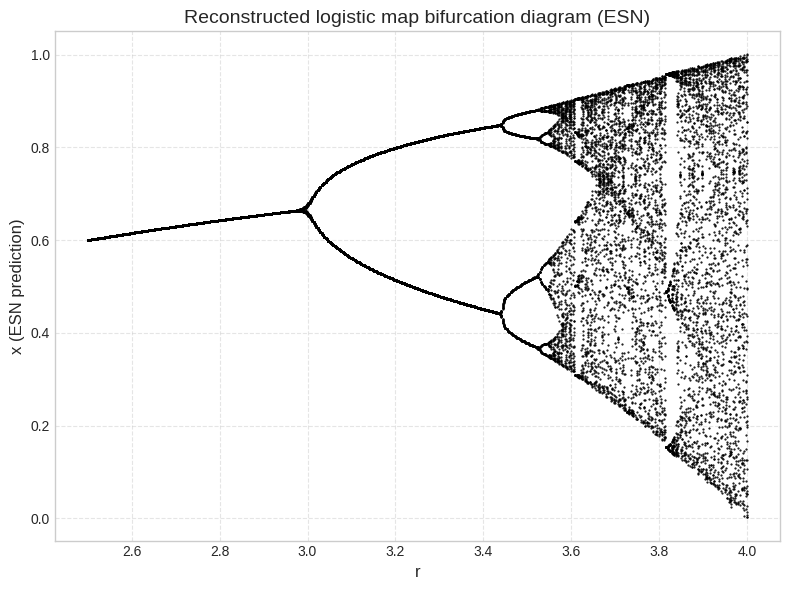

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define the logistic map function
def logistic_map(x, r):
    return r * x * (1 - x)

# Echo State Network (ESN) training function
def train_esn(esn_params, training_data):
    """
    Train an ESN on given training data.
    
    esn_params: dict with keys 'reservoir_size', 'input_scaling', 'spectral_radius', 
                'leak_rate', 'ridge_reg'
    training_data: list of tuples (r, x_init, length) specifying parameter value r,
                   initial x, and sequence length to generate for training.
                   
    Returns: Win, W, Wout, leak_rate
    """
    N = esn_params['reservoir_size']
    leak = esn_params['leak_rate']
    input_scaling = esn_params['input_scaling']
    spectral_radius = esn_params['spectral_radius']
    ridge_reg = esn_params['ridge_reg']
    
    # Initialize input and reservoir weights
    Win = (np.random.rand(N, 2) - 0.5) * input_scaling  # 2 inputs: [x, r]
    W = np.random.rand(N, N) - 0.5
    # Scale reservoir weights to given spectral radius
    eigvals = np.linalg.eigvals(W)
    W *= (spectral_radius / np.max(np.abs(eigvals)))
    
    # Collect state vectors and targets for ridge regression
    collected_states = []
    collected_targets = []
    
    for (r, x0, length) in training_data:
        x = x0
        state = np.zeros(N)
        # Washout period to let reservoir state stabilize
        washout = 100
        for _ in range(washout):
            inp = np.array([x, r])
            state = (1 - leak) * state + leak * np.tanh(Win.dot(inp) + W.dot(state))
            x = logistic_map(x, r)
        # Generate training sequence
        for _ in range(length):
            inp = np.array([x, r])
            state = (1 - leak) * state + leak * np.tanh(Win.dot(inp) + W.dot(state))
            # Append [state; inputs; bias] as features
            feat = np.hstack([state, x, r, 1.0])
            x = logistic_map(x, r)
            collected_states.append(feat)
            collected_targets.append(x)
    
    # Convert collected data to numpy arrays
    X = np.vstack(collected_states)           # shape: (total_time, N+3)
    Y = np.array(collected_targets).reshape(-1, 1)  # shape: (total_time, 1)
    # Train output weights with ridge regression
    # Solve: (X^T X + reg*I) Wout^T = X^T Y
    reg = ridge_reg
    I = np.eye(X.shape[1])
    Wout = np.linalg.solve(X.T.dot(X) + reg * I, X.T.dot(Y)).T  # shape: (1, N+3)
    
    return Win, W, Wout, leak

# ESN prediction function with mixed teacher forcing and free-run
def predict_bifurcation(Win, W, Wout, leak, r_values, teacher_steps=100, predict_steps=100):
    """
    Reconstruct bifurcation data for given r_values using the trained ESN.
    We use teacher-forcing for 'teacher_steps' iterations (using the true map to drive state),
    then switch to autonomous prediction for 'predict_steps', collecting outputs.
    
    Returns a list of predicted time series (length predict_steps) for each r in r_values.
    """
    N = Win.shape[0]
    results = []
    for r in r_values:
        # Initialize with fixed initial condition
        x = 0.1
        state = np.zeros(N)
        # Teacher forcing to settle into attractor
        for _ in range(teacher_steps):
            inp = np.array([x, r])
            state = (1 - leak) * state + leak * np.tanh(Win.dot(inp) + W.dot(state))
            x = logistic_map(x, r)
        # Autonomous prediction
        series = []
        for _ in range(predict_steps):
            inp = np.array([x, r])
            state = (1 - leak) * state + leak * np.tanh(Win.dot(inp) + W.dot(state))
            feat = np.hstack([state, x, r, 1.0])
            y = Wout.dot(feat)  # network output
            x = y.item()
            series.append(x)
        results.append(series)
    return results

# Main script: set up ESN, train, and reconstruct bifurcation diagram
if __name__ == "__main__":
    # Hyperparameters for the ESN
    esn_params = {
        'reservoir_size': 300,
        'input_scaling': 0.5,
        'spectral_radius': 0.9,
        'leak_rate': 0.3,
        'ridge_reg': 1e-6
    }
    # Define training data: list of (r, initial x, sequence length)
    # Use several r-values spanning [2.5, 4.0] to cover different dynamic regimes
    train_rs = np.linspace(2.5, 4.0, 7)
    training_data = [(r, 0.1, 1000) for r in train_rs]
    
    # Train the ESN
    Win, W, Wout, leak = train_esn(esn_params, training_data)
    
    # Reconstruct bifurcation diagram:
    # Choose a grid of r values
    r_values = np.linspace(2.5, 4.0, 500)
    # Use teacher forcing for 100 steps, then predict 100 steps
    predictions = predict_bifurcation(Win, W, Wout, leak, r_values, teacher_steps=100, predict_steps=100)
    
    # Prepare data for plotting
    plot_r = []
    plot_x = []
    for (r, series) in zip(r_values, predictions):
        # Take last 50 points from each series to illustrate attractor (skip transient)
        for x in series[-50:]:
            plot_r.append(r)
            plot_x.append(x)
    
    # Plot the reconstructed bifurcation diagram
    plt.figure(figsize=(8,6))
    plt.scatter(plot_r, plot_x, s=0.3, color='black')
    plt.title("Reconstructed logistic map bifurcation diagram (ESN)", fontsize=14)
    plt.xlabel("r", fontsize=12)
    plt.ylabel("x (ESN prediction)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
